# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<b>The objective is to develop a preidction regression model to estimate the price of used cars based on relevant features which are key value parameters for the customers. Price of a used car could vary based on make, model, year, engine type, condition, fuel efficiency etc.</b>

<b>This involves identifying and quantifying key predictors by using exploratory data analysis and feature engineering methodologies. The goal is to improve pricing accuracy based on insights provided by data and help in strategic data-driven decision making.</b>

<h2>2. Data Understanding</h2>

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

We would perform below steps to understand the data and indentify any quality issues:

1. Data preprocessing
   - Cleaning the data
   - Transforming the data
   - Preparing the data for model
2. Feature Engineering
   - Identify most important features
   - Perform PCA to reduce number of relevant features
   - Check relevance of higher order feature interaction   

In [127]:
%%capture
%pip install plotly
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install vininfo
%pip install vin
%pip install pyvin
%pip install aiohttp
%pip install category_encoders
%pip install mlflow
%pip install xgboost
%pip install catboost
%pip install IPython
%pip install graphviz
%pip install tabulate

In [128]:
# import required python libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import textwrap
import time
import mlflow

from vin import VIN
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import set_config
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from IPython.display import SVG
from graphviz import Source
from tabulate import tabulate

set_config(display='diagram')
%matplotlib inline

In [3]:
nb_start_time = time.time()

In [4]:
# mlflow.sklearn.autolog()

In [5]:
# Utility functions
# Wrap labels for x-axis
def wrap_labels(ax, width, n, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width, break_long_words=break_long_words))
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_xticklabels(labels, rotation=0)

<h3>1.1 Understanding variables & data</h3>

In [6]:
# Read dataset using pandas
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.head()

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

In [7]:
# Check tail of the dataset
vehicles.tail()

id   region  price    year manufacturer  \
426875  7301591192  wyoming  23590  2019.0       nissan   
426876  7301591187  wyoming  30590  2020.0        volvo   
426877  7301591147  wyoming  34990  2020.0     cadillac   
426878  7301591140  wyoming  28990  2018.0        lexus   
426879  7301591129  wyoming  30590  2019.0          bmw   

                           model condition    cylinders    fuel  odometer  \
426875         maxima s sedan 4d      good  6 cylinders     gas   32226.0   
426876  s60 t5 momentum sedan 4d      good          NaN     gas   12029.0   
426877          xt4 sport suv 4d      good          NaN  diesel    4174.0   
426878           es 350 sedan 4d      good  6 cylinders     gas   30112.0   
426879  4 series 430i gran coupe      good          NaN     gas   22716.0   

       title_status transmission                VIN drive size       type  \
426875        clean        other  1N4AA6AV6KC367801   fwd  NaN      sedan   
426876        clean        other  7JR102FKXLG042696   fwd  NaN      sedan   
426877        clean        other  1GYFZFR46LF088296   NaN  NaN  hatchback   
426878        clean        other  58ABK1GG4JU103853   fwd  NaN      sedan   
426879        clean        other  WBA4J1C58KBM14708   rwd  NaN      coupe   

       paint_color state  
426875         NaN    wy  
426876         red    wy  
426877       white    wy  
426878      silver    wy  
426879         NaN    wy

In [8]:
# Check general stats of the dataset 
vehicles.describe()

id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07

In [9]:
# Check schema of the dataset, null values and data type of each column
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [10]:
# Check percentage of missing values for the columns which have more non-zero missing values
def find_missing_values_percentage(v):
    missing_values_all = v.isna().sum()
    missing_values = missing_values_all[missing_values_all > 0]
    missing_values_percentage = (missing_values / v.shape[0]) * 100
    return missing_values_percentage

missing_values_percent = find_missing_values_percentage(vehicles)
missing_values_percent

year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
dtype: float64

In [11]:
# Get unique values for each column
def get_unique_values(v):
    for col in v.columns:
        if v[col].isna().sum() > 0:
            unique_values = v[col].unique()
            print(f'Unique values for {col}: {unique_values}\n')

get_unique_values(vehicles) 

Unique values for year: [  nan 2014. 2010. 2020. 2017. 2013. 2012. 2016. 2019. 2011. 1992. 2018.
 2004. 2015. 2001. 2006. 1968. 2003. 2008. 2007. 2005. 1966. 2009. 1998.
 2002. 1999. 2021. 1997. 1976. 1969. 1995. 1978. 1954. 1979. 1970. 1974.
 1996. 1987. 2000. 1955. 1960. 1991. 1972. 1988. 1994. 1929. 1984. 1986.
 1989. 1973. 1946. 1933. 1958. 1937. 1985. 1957. 1953. 1942. 1963. 1977.
 1993. 1903. 1990. 1965. 1982. 1948. 1983. 1936. 1932. 1951. 1931. 1980.
 1967. 1971. 1947. 1981. 1926. 1962. 1975. 1964. 1934. 1952. 1940. 1959.
 1950. 1930. 1956. 1922. 1928. 2022. 1901. 1941. 1924. 1927. 1939. 1923.
 1949. 1961. 1935. 1918. 1900. 1938. 1913. 1916. 1943. 1925. 1921. 1915.
 1945. 1902. 1905. 1920. 1944. 1910. 1909.]

Unique values for manufacturer: [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubis

<h3>1.2 Data type transformation</h3>

In [12]:
# Convert object data type to string type
def convert_feature_dtype():
    for col in vehicles.select_dtypes(include='object').columns:
        vehicles[col] = vehicles[col].astype('string')

convert_feature_dtype()
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  string 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  string 
 5   model         421603 non-null  string 
 6   condition     252776 non-null  string 
 7   cylinders     249202 non-null  string 
 8   fuel          423867 non-null  string 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  string 
 11  transmission  424324 non-null  string 
 12  VIN           265838 non-null  string 
 13  drive         296313 non-null  string 
 14  size          120519 non-null  string 
 15  type          334022 non-null  string 
 16  paint_color   296677 non-null  string 
 17  state         426880 non-null  string 
dtypes: f

### Summary

* Dataset size is 426880 X 18.
* Many columns have missing values.
* Size column have ~72%+ values missing.
* We performed data type transformation to convert object data type to string type

<h2>2. Data Preparation</h2>

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

<h3>2.1 Data Wrangling</h3>

In [13]:
# Drop columns
# Drop id, as it is not useful for our analysis
# Drop size column as ~72% of the values are missing.
vehicles_df = vehicles.drop(['id', 'size'], axis=1)
vehicles_df.tail()

region  price    year manufacturer                     model  \
426875  wyoming  23590  2019.0       nissan         maxima s sedan 4d   
426876  wyoming  30590  2020.0        volvo  s60 t5 momentum sedan 4d   
426877  wyoming  34990  2020.0     cadillac          xt4 sport suv 4d   
426878  wyoming  28990  2018.0        lexus           es 350 sedan 4d   
426879  wyoming  30590  2019.0          bmw  4 series 430i gran coupe   

       condition    cylinders    fuel  odometer title_status transmission  \
426875      good  6 cylinders     gas   32226.0        clean        other   
426876      good         <NA>     gas   12029.0        clean        other   
426877      good         <NA>  diesel    4174.0        clean        other   
426878      good  6 cylinders     gas   30112.0        clean        other   
426879      good         <NA>     gas   22716.0        clean        other   

                      VIN drive       type paint_color state  
426875  1N4AA6AV6KC367801   fwd      sedan        <NA>    wy  
426876  7JR102FKXLG042696   fwd      sedan         red    wy  
426877  1GYFZFR46LF088296  <NA>  hatchback       white    wy  
426878  58ABK1GG4JU103853   fwd      sedan      silver    wy  
426879  WBA4J1C58KBM14708   rwd      coupe        <NA>    wy

<Axes: >

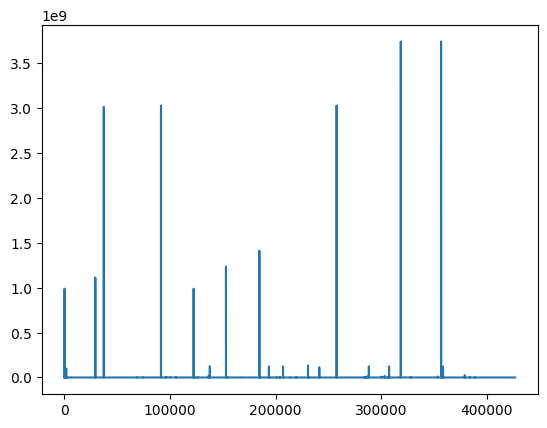

In [14]:
# Visualize price column to understand if there are outliers
vehicles_df['price'].plot()

In [15]:
# Apply VIN based imputation for year, make, model and vehicle type columns
def fill_vehicle_year(row):
    try:
        vin = VIN(row.VIN)
        return vin.model_year
    except BaseException:
        return row.year

def fill_vehicle_manufacturer(row):
    try:
        vin = VIN(row.VIN)
        return vin.make.lower()
    except BaseException:
        return row.manufacturer

def fill_vehicle_model(row):
    try:
        vin = VIN(row.VIN)
        return vin.model.lower()
    except BaseException:
        return row.model

def fill_vehicle_type(row):
    try:
        vin = VIN(row.VIN)
        return vin.body_class.lower()
    except BaseException:
        return row.type
        
def vin_based_imputation(col):
    if col == 'year':
        vehicles_year = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_year.index, col] = vehicles_year.apply(fill_vehicle_year, axis=1)
    elif col == 'manufacturer':
        vehicles_make = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_make.index, col] = vehicles_make.apply(fill_vehicle_manufacturer, axis=1)
    elif col == 'model':
        vehicles_model = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_model.index, col] = vehicles_model.apply(fill_vehicle_model, axis=1)
    elif col == 'type':
        vehicles_type = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_type.index, col] = vehicles_type.apply(fill_vehicle_type, axis=1)
    return vehicles_df
    
vehicles_df = vin_based_imputation('year')
vehicles_df = vin_based_imputation('manufacturer')
vehicles_df = vin_based_imputation('model')
types = vehicles_df['type'].unique()
vehicles_df = vin_based_imputation('type')
vehicles_df.tail()

region  price    year manufacturer                     model  \
426875  wyoming  23590  2019.0       nissan         maxima s sedan 4d   
426876  wyoming  30590  2020.0        volvo  s60 t5 momentum sedan 4d   
426877  wyoming  34990  2020.0     cadillac          xt4 sport suv 4d   
426878  wyoming  28990  2018.0        lexus           es 350 sedan 4d   
426879  wyoming  30590  2019.0          bmw  4 series 430i gran coupe   

       condition    cylinders    fuel  odometer title_status transmission  \
426875      good  6 cylinders     gas   32226.0        clean        other   
426876      good         <NA>     gas   12029.0        clean        other   
426877      good         <NA>  diesel    4174.0        clean        other   
426878      good  6 cylinders     gas   30112.0        clean        other   
426879      good         <NA>     gas   22716.0        clean        other   

                      VIN drive       type paint_color state  
426875  1N4AA6AV6KC367801   fwd      sedan        <NA>    wy  
426876  7JR102FKXLG042696   fwd      sedan         red    wy  
426877  1GYFZFR46LF088296  <NA>  hatchback       white    wy  
426878  58ABK1GG4JU103853   fwd      sedan      silver    wy  
426879  WBA4J1C58KBM14708   rwd      coupe        <NA>    wy

In [16]:
missing_values_percent = find_missing_values_percentage(vehicles_df)
missing_values_percent

year             0.044978
manufacturer     2.837566
model            0.871674
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
type            15.975216
paint_color     30.501078
dtype: float64

In [17]:
# Drop rows where nan
def drop_nan_rows(vehicles_df, col):
    total_rows = vehicles_df.shape[0]
    vehicles_df = vehicles_df[vehicles_df[col].notna()]
    not_nan_count = len(vehicles_df)
    print(f'Total rows: {total_rows}')
    print(f'Rows dropped with {col}=NaN : {total_rows - not_nan_count}')
    return vehicles_df

In [18]:
# Drop rows where year and odometer is nan
vehicles_df = drop_nan_rows(vehicles_df, 'year')
vehicles_df = drop_nan_rows(vehicles_df, 'odometer')
vehicles_df.head()

Total rows: 426880
Rows dropped with year=NaN : 192
Total rows: 426688
Rows dropped with odometer=NaN : 4331


region  price    year manufacturer                     model  condition  \
27  auburn  33590  2014.0          gmc  sierra 1500 crew cab slt       good   
28  auburn  22590  2010.0    chevrolet            silverado 1500       good   
29  auburn  39590  2020.0    chevrolet       silverado 1500 crew       good   
30  auburn  30990  2017.0       toyota      tundra double cab sr       good   
31  auburn  15000  2013.0         ford                 f-150 xlt  excellent   

      cylinders fuel  odometer title_status transmission                VIN  \
27  8 cylinders  gas   57923.0        clean        other  3GTP1VEC4EG551563   
28  8 cylinders  gas   71229.0        clean        other  1GCSCSE06AZ123805   
29  8 cylinders  gas   19160.0        clean        other  3GCPWCED5LG130317   
30  8 cylinders  gas   41124.0        clean        other  5TFRM5F17HX120972   
31  6 cylinders  gas  128000.0        clean    automatic               <NA>   

   drive    type paint_color state  
27  <NA>  pickup       white    al  
28  <NA>  pickup        blue    al  
29  <NA>  pickup         red    al  
30  <NA>  pickup         red    al  
31   rwd   truck       black    al

In [19]:
# Remove outliers for price, odometer, year
def remove_outliers(vehicles_df):
    Q1 = vehicles_df['price'].quantile(0.25)
    median = vehicles_df['price'].quantile(0.50)
    Q3 = vehicles_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows within bounds
    vehicles_df['price'] = np.where(vehicles_df['price'] > upper_bound, median, np.where(vehicles_df['price'] < lower_bound, median, vehicles_df['price']))

    # Impute zero value of price with median
    filter_price_zero = (vehicles_df['price'] == 0) & (vehicles_df['condition'].notna()) & (vehicles_df['title_status'].notna())
    vehicles_price_zero_df = vehicles_df[filter_price_zero]    
    vehicles_df.loc[vehicles_price_zero_df.index, 'price'] = median

    # Drop rows where price=0 and (condition=nan or title_status=nan)
    drop_price_zero = ((vehicles_df['price'] == 0) & ((vehicles_df['condition'].isna()) | (vehicles_df['title_status'].isna())))
    vehicles_drop_price_zero_df = vehicles_df[drop_price_zero]   
    total_rows = vehicles_df.shape[0]
    vehicles_df = vehicles_df.drop(vehicles_drop_price_zero_df.index)
    print(f'Total rows: {total_rows}')
    print(f'Rows dropped with price=0 & (condition=NaN | title=NaN) : {total_rows - vehicles_df.shape[0]}')

    # Removing outliers by Capping:
    for col in ['odometer', 'year']:
      upper_limit = vehicles_df[col].quantile(0.99)
      vehicles_df[col] = np.where(vehicles_df[col] > upper_limit, upper_limit, vehicles_df[col])
    return vehicles_df

vehicles_df = remove_outliers(vehicles_df)
vehicles_df.head()

Total rows: 422357
Rows dropped with price=0 & (condition=NaN | title=NaN) : 21100


region    price    year manufacturer                     model  condition  \
27  auburn  33590.0  2014.0          gmc  sierra 1500 crew cab slt       good   
28  auburn  22590.0  2010.0    chevrolet            silverado 1500       good   
29  auburn  39590.0  2020.0    chevrolet       silverado 1500 crew       good   
30  auburn  30990.0  2017.0       toyota      tundra double cab sr       good   
31  auburn  15000.0  2013.0         ford                 f-150 xlt  excellent   

      cylinders fuel  odometer title_status transmission                VIN  \
27  8 cylinders  gas   57923.0        clean        other  3GTP1VEC4EG551563   
28  8 cylinders  gas   71229.0        clean        other  1GCSCSE06AZ123805   
29  8 cylinders  gas   19160.0        clean        other  3GCPWCED5LG130317   
30  8 cylinders  gas   41124.0        clean        other  5TFRM5F17HX120972   
31  6 cylinders  gas  128000.0        clean    automatic               <NA>   

   drive    type paint_color state  
27  <NA>  pickup       white    al  
28  <NA>  pickup        blue    al  
29  <NA>  pickup         red    al  
30  <NA>  pickup         red    al  
31   rwd   truck       black    al

In [20]:
# Data fix for model value=1500 based on manufactures and model
def fix_car_model():
    model_ram_df = vehicles_df[(vehicles_df['manufacturer'] == 'ram') & (vehicles_df['model'] == '1500')]
    model_gmc_df = vehicles_df[(vehicles_df['manufacturer'] == 'gmc') & (vehicles_df['model'] == '1500')]
    model_chevrolet_df = vehicles_df[(vehicles_df['manufacturer'] == 'chevrolet') & (vehicles_df['model'] == '1500')]

    vehicles_df.loc[model_ram_df.index, 'model'] = '1500 laramie'
    vehicles_df.loc[model_gmc_df.index, 'model'] = 'sierra 1500'
    vehicles_df.loc[model_chevrolet_df.index, 'model'] = 'silverado 1500'
    return vehicles_df

vehicles_df = fix_car_model()

In [21]:
vehicles['type'].unique()

<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string

In [22]:
# Convert year from float to integer
vehicles_df['year'] = vehicles_df['year'].astype('int64')
vehicles_df.head()

region    price  year manufacturer                     model  condition  \
27  auburn  33590.0  2014          gmc  sierra 1500 crew cab slt       good   
28  auburn  22590.0  2010    chevrolet            silverado 1500       good   
29  auburn  39590.0  2020    chevrolet       silverado 1500 crew       good   
30  auburn  30990.0  2017       toyota      tundra double cab sr       good   
31  auburn  15000.0  2013         ford                 f-150 xlt  excellent   

      cylinders fuel  odometer title_status transmission                VIN  \
27  8 cylinders  gas   57923.0        clean        other  3GTP1VEC4EG551563   
28  8 cylinders  gas   71229.0        clean        other  1GCSCSE06AZ123805   
29  8 cylinders  gas   19160.0        clean        other  3GCPWCED5LG130317   
30  8 cylinders  gas   41124.0        clean        other  5TFRM5F17HX120972   
31  6 cylinders  gas  128000.0        clean    automatic               <NA>   

   drive    type paint_color state  
27  <NA>  pickup       white    al  
28  <NA>  pickup        blue    al  
29  <NA>  pickup         red    al  
30  <NA>  pickup         red    al  
31   rwd   truck       black    al

In [23]:
# Fix car type data
def fix_car_type():
    type_sport_df = vehicles_df[vehicles_df['type']== 'sport utility vehicle (suv)/multi-purpose vehicle (mpv)']
    type_cuv_df = vehicles_df[vehicles_df['type']== 'crossover utility vehicle (cuv)']
    type_van_df = vehicles_df[vehicles_df['type']== 'step van / walk-in van']
    type_chasis_df = vehicles_df[vehicles_df['type']== 'incomplete - chassis cab (single cab)']
    type_sut_df = vehicles_df[vehicles_df['type']== 'sport utility truck (sut)']
    type_hatchback_df = vehicles_df[vehicles_df['type']== 'hatchback/liftback/notchback']
    type_minivan_df = vehicles_df[vehicles_df['type']== 'minivan']
    type_sedan_df = vehicles_df[vehicles_df['type']== 'sedan/saloon']

    vehicles_df.loc[type_sport_df.index, 'type'] = 'SUV'
    vehicles_df.loc[type_cuv_df.index, 'type'] = 'CUV'
    vehicles_df.loc[type_van_df.index, 'type'] = 'van'
    vehicles_df.loc[type_chasis_df.index, 'type'] = 'chassis cab'
    vehicles_df.loc[type_sut_df.index, 'type'] = 'SUT'
    vehicles_df.loc[type_hatchback_df.index, 'type'] = 'hatchback'
    vehicles_df.loc[type_minivan_df.index, 'type'] = 'mini-van'
    vehicles_df.loc[type_sedan_df.index, 'type'] = 'sedan'
    return vehicles_df

vehicles_df = fix_car_type()
vehicles_df['type'].value_counts()

type
sedan                    86420
SUV                      79727
pickup                   47616
truck                    32003
other                    20268
coupe                    19011
hatchback                17038
wagon                    10442
van                       8368
convertible               7512
mini-van                  5491
cargo van                  635
offroad                    609
bus                        517
CUV                        310
convertible/cabriolet      247
truck-tractor              117
SUT                         51
fire apparatus              36
roadster                    16
chassis cab                  1
Name: count, dtype: Int64

In [24]:
# Transform and fix cylinders column
# Change cyclinders to numeric column
vehicles_df['num_cylinders'] = 0

def transform_cylinders(vehicles_df):
    v8_df = vehicles_df[vehicles_df['cylinders'] == '8 cylinders']
    v6_df = vehicles_df[vehicles_df['cylinders'] == '6 cylinders']
    v4_df = vehicles_df[vehicles_df['cylinders'] == '4 cylinders']
    v5_df = vehicles_df[vehicles_df['cylinders'] == '5 cylinders']
    v3_df = vehicles_df[vehicles_df['cylinders'] == '3 cylinders']
    v10_df = vehicles_df[vehicles_df['cylinders'] == '10 cylinders']
    v12_df = vehicles_df[vehicles_df['cylinders'] == '12 cylinders']
    v_other_df = vehicles_df[vehicles_df['cylinders'] == 'other']

    vehicles_df.loc[v8_df.index , 'num_cylinders'] = 8
    vehicles_df.loc[v6_df.index , 'num_cylinders'] = 6
    vehicles_df.loc[v4_df.index , 'num_cylinders'] = 4
    vehicles_df.loc[v5_df.index , 'num_cylinders'] = 5
    vehicles_df.loc[v3_df.index , 'num_cylinders'] = 3
    vehicles_df.loc[v10_df.index , 'num_cylinders'] = 10
    vehicles_df.loc[v12_df.index , 'num_cylinders'] = 12
    vehicles_df.loc[v_other_df.index , 'num_cylinders'] = np.nan
    return vehicles_df

vehicles_df = transform_cylinders(vehicles_df)
vehicles_df.head()

region    price  year manufacturer                     model  condition  \
27  auburn  33590.0  2014          gmc  sierra 1500 crew cab slt       good   
28  auburn  22590.0  2010    chevrolet            silverado 1500       good   
29  auburn  39590.0  2020    chevrolet       silverado 1500 crew       good   
30  auburn  30990.0  2017       toyota      tundra double cab sr       good   
31  auburn  15000.0  2013         ford                 f-150 xlt  excellent   

      cylinders fuel  odometer title_status transmission                VIN  \
27  8 cylinders  gas   57923.0        clean        other  3GTP1VEC4EG551563   
28  8 cylinders  gas   71229.0        clean        other  1GCSCSE06AZ123805   
29  8 cylinders  gas   19160.0        clean        other  3GCPWCED5LG130317   
30  8 cylinders  gas   41124.0        clean        other  5TFRM5F17HX120972   
31  6 cylinders  gas  128000.0        clean    automatic               <NA>   

   drive    type paint_color state  num_cylinders  
27  <NA>  pickup       white    al            8.0  
28  <NA>  pickup        blue    al            8.0  
29  <NA>  pickup         red    al            8.0  
30  <NA>  pickup         red    al            8.0  
31   rwd   truck       black    al            6.0

In [25]:
vehicles_df['num_cylinders'].unique()

array([ 8.,  6.,  0.,  4.,  5., nan,  3., 10., 12.])

In [26]:
# Set number of cyclinders for electric cars to zero
def fix_cylinders_for_electric_vehicle(vehicles_df):
    v_fuel_electric = vehicles_df[(vehicles_df['fuel'] == 'electric')]
    vehicles_df.loc[v_fuel_electric.index , 'num_cylinders'] = 0
    return vehicles_df

vehicles_df = fix_cylinders_for_electric_vehicle(vehicles_df)
vehicles_df[(vehicles_df['fuel'] == 'electric')]['num_cylinders'].unique()

array([0.])

In [27]:
#Perform ordinal encoding for title_status, condition, drive and vehicle type of vehicles
def ordinal_encode(vehicles_df, col, categories): 
    # Create encoder
    encoder = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
    
    # Fit and transform
    vehicles_df[f'vehicle_{col}'] = encoder.fit_transform(vehicles_df[[col]])
    return vehicles_df


#Define custom order
title_categories = [['parts only', 'missing', 'salvage', 'rebuilt', 'lien', 'clean']]  # ordered worst to best
vehicles_df = ordinal_encode(vehicles_df, 'title_status', title_categories)

condition_categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']] # ordered worst to best
vehicles_df = ordinal_encode(vehicles_df, 'condition', condition_categories)

drive_categories = [['fwd', 'rwd', '4wd']] # ordered worst to best
vehicles_df = ordinal_encode(vehicles_df, 'drive', drive_categories)

type_categories = [['other', 'mini-van', 'hatchback', 'sedan', 'coupe', 'wagon', 'SUV', 'van', 'pickup', 'offroad', 'truck', 'convertible', 'bus']]
vehicles_df = ordinal_encode(vehicles_df, 'type', type_categories)

In [28]:
# Find interaction between features
def find_feature_interaction(vehicles_df):
    vehicles_df = vehicles_df.reset_index(drop=True)
    vehicles_df['vehicle_age'] = (2025 - vehicles_df['year']).astype('float64')
    vehicles_df['log_vehicle_age'] = np.log1p(vehicles_df['vehicle_age'])
    vehicles_df['vehicle_age_odometer_ratio'] = vehicles_df['odometer'] / vehicles_df['vehicle_age'].replace(0, 1)
    vehicles_df['vehicle_age_condition'] = vehicles_df['vehicle_age'] * vehicles_df['vehicle_condition']
    vehicles_df['title_good_condition'] = vehicles_df['vehicle_title_status'] * vehicles_df['vehicle_condition']
    # vehicles_df['high_mileage_bad_condition'] = vehicles_df['odometer'] * vehicles_df['vehicle_condition']
    return vehicles_df

vehicles_df = find_feature_interaction(vehicles_df)
vehicles_df.head()

region    price  year manufacturer                     model  condition  \
0  auburn  33590.0  2014          gmc  sierra 1500 crew cab slt       good   
1  auburn  22590.0  2010    chevrolet            silverado 1500       good   
2  auburn  39590.0  2020    chevrolet       silverado 1500 crew       good   
3  auburn  30990.0  2017       toyota      tundra double cab sr       good   
4  auburn  15000.0  2013         ford                 f-150 xlt  excellent   

     cylinders fuel  odometer title_status  ... num_cylinders  \
0  8 cylinders  gas   57923.0        clean  ...           8.0   
1  8 cylinders  gas   71229.0        clean  ...           8.0   
2  8 cylinders  gas   19160.0        clean  ...           8.0   
3  8 cylinders  gas   41124.0        clean  ...           8.0   
4  6 cylinders  gas  128000.0        clean  ...           6.0   

  vehicle_title_status vehicle_condition vehicle_drive vehicle_type  \
0                  5.0               2.0          -1.0          8.0   
1                  5.0               2.0          -1.0          8.0   
2                  5.0               2.0          -1.0          8.0   
3                  5.0               2.0          -1.0          8.0   
4                  5.0               3.0           1.0         10.0   

  vehicle_age  log_vehicle_age  vehicle_age_odometer_ratio  \
0        11.0         2.484907                 5265.727273   
1        15.0         2.772589                 4748.600000   
2         5.0         1.791759                 3832.000000   
3         8.0         2.197225                 5140.500000   
4        12.0         2.564949                10666.666667   

   vehicle_age_condition  title_good_condition  
0                   22.0                  10.0  
1                   30.0                  10.0  
2                   10.0                  10.0  
3                   16.0                  10.0  
4                   36.0                  15.0  

[5 rows x 26 columns]

In [29]:
#Perform OHE for certain categorical columns
def OHE_encoding(v_df, col):
    dummies = pd.get_dummies(v_df[col], prefix=col, dtype='float64')
    return dummies

vehicles_df = pd.concat([vehicles_df, OHE_encoding(vehicles_df, 'transmission')], axis=1)
vehicles_df = pd.concat([vehicles_df, OHE_encoding(vehicles_df, 'fuel')], axis=1)
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401257 entries, 0 to 401256
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   region                      401257 non-null  string 
 1   price                       401257 non-null  float64
 2   year                        401257 non-null  int64  
 3   manufacturer                390346 non-null  string 
 4   model                       397790 non-null  string 
 5   condition                   250851 non-null  string 
 6   cylinders                   238799 non-null  string 
 7   fuel                        399012 non-null  string 
 8   odometer                    401257 non-null  float64
 9   title_status                393814 non-null  string 
 10  transmission                399729 non-null  string 
 11  VIN                         247236 non-null  string 
 12  drive                       279016 non-null  string 
 13  type          

### Summary of Data Wrangling

* Drop id column, as it is not useful for our analysis.
* Drop size column as ~72% of the values are missing.
* Apply VIN based imputation for year, make, model and vehicle type columns using python library (vin)
* Droped rows with NaN values which could not imputed.
  * 192 rows for year column
  * 4331 rows for odometer column
* Observed outliers in price column.
  * We used IQR to remove outliers from price column.
  * Impute zero value of price with median when condition != NaN and title_status != Nan
  * Drop rows where price=0 and (condition=nan or title_status=nan)
* Removed outliers above 99 percentile for price and odometer columns.
* Impute vehicle model based on manufacturer and model where model value=1500.
* Convert year column data type from float to integer.
* Impute vehicle type by merging similar types of vehicle and abbreviating long names of car type.
* Transform cylinders by adding a new numeric column(num_cylinders).
  * Initialize num_cylinders colums with 0.
  * Assigned corropspnding numeric value of cylinders to num_cylinders column.
  * Set NaN for cylinders type of 'Other'. Used make, model and vehicle type to impute cylinders with NaN value.
  * Set num_cylinders for elctric vehicles to 0
* Performed ordinal encoding for below columns
  * title_status
  * condition
  * type
  * drive
* Added new columns based on features interaction
  * vehicle_age: Absolute age of the vehicle in years.
  * log_vehicle_age: Vehicle does not decline linearly. So, log of age represents depreciation more accurately.
  * vehicle_age_odometer_ratio: (Vehicle wear rate) Ratio of odometer and vehicle age ratio
  * vehicle_age_condition: Helps identify if older cars are in surprisingly good/bad condition.
  * title_good_condition: Clean + good condition = better resale value.

<h3>2.2 Data Visualization</h3>

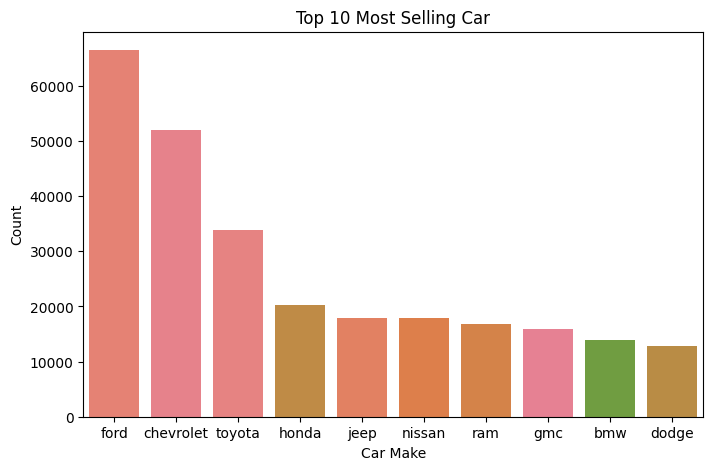

In [30]:
# Top 10 selling cars
top10 = vehicles_df['manufacturer'].value_counts()[:10]

# Create a count plot to visualize the top 10 car
plt.figure(figsize=(8, 5))
sns.countplot(x='manufacturer', data=vehicles_df, order=top10.index, hue='manufacturer')

# Set labels and title for the plot
plt.xlabel('Car Make')
plt.ylabel('Count')
plt.title('Top 10 Most Selling Car')

# Display the plot
plt.savefig('images/top10_selling_car.png')
plt.show()

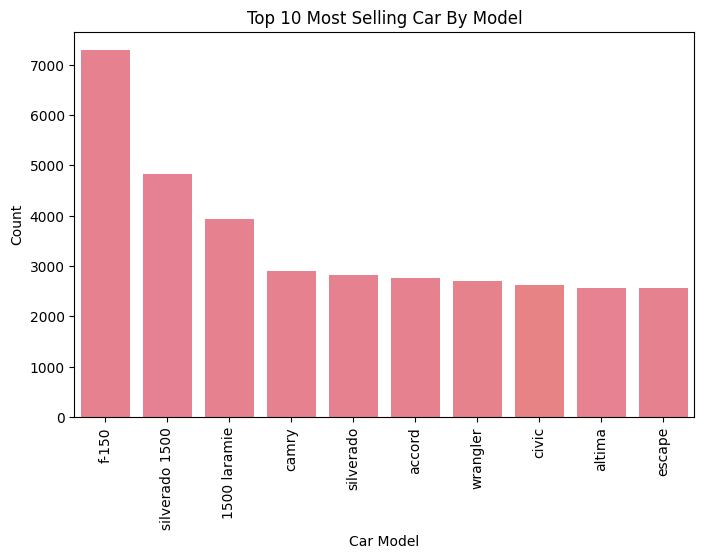

In [31]:
# Top 10 selling cars by model
top10model = vehicles_df['model'].value_counts()[:10]

# Create a count plot to visualize the top 10 car
plt.figure(figsize=(8, 5))
sns.countplot(x='model', data=vehicles_df, order=top10model.index, hue='model')

# Set labels and title for the plot
plt.xlabel('Car Model')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Top 10 Most Selling Car By Model')

# Display the plot
plt.savefig('images/top10_selling_car_by_model.png')
plt.show()

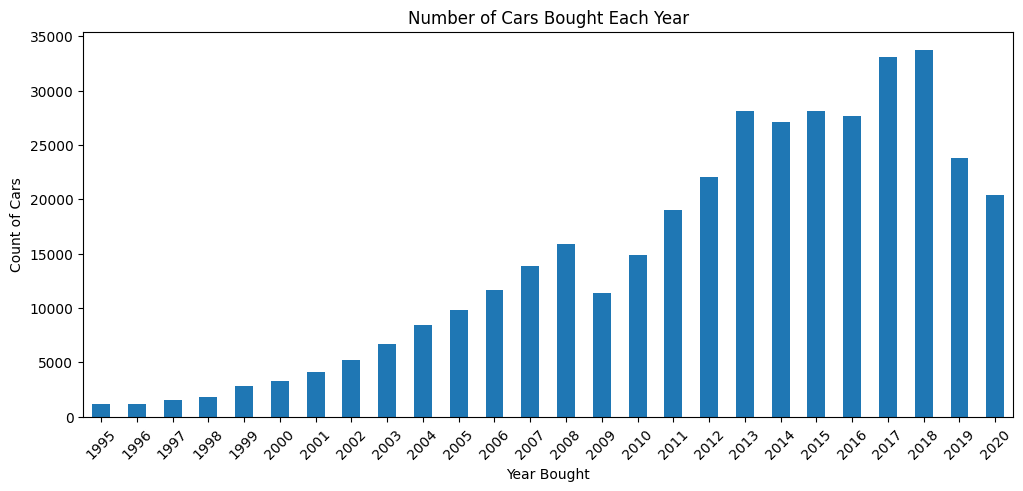

In [32]:
# Bar plot visualization for Number of Cars Bought Each Year During Last 25 Years
# Set the figure size for the plot
plt.figure(figsize=(12, 5))

# Group the data by the 'Year' column and count the number of occurrences for each year
yearly_counts = vehicles_df[vehicles_df['year'] >= 1995].groupby('year').count()['manufacturer']
yearly_counts

# Create a bar plot to visualize the count of cars bought in each year
yearly_counts.plot(kind='bar')

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Set labels and title for the plot
plt.xlabel('Year Bought')
plt.ylabel('Count of Cars')
plt.title('Number of Cars Bought Each Year')

# Display and save the plot
plt.savefig('images/top10_selling_car_by_year.png')
plt.show()

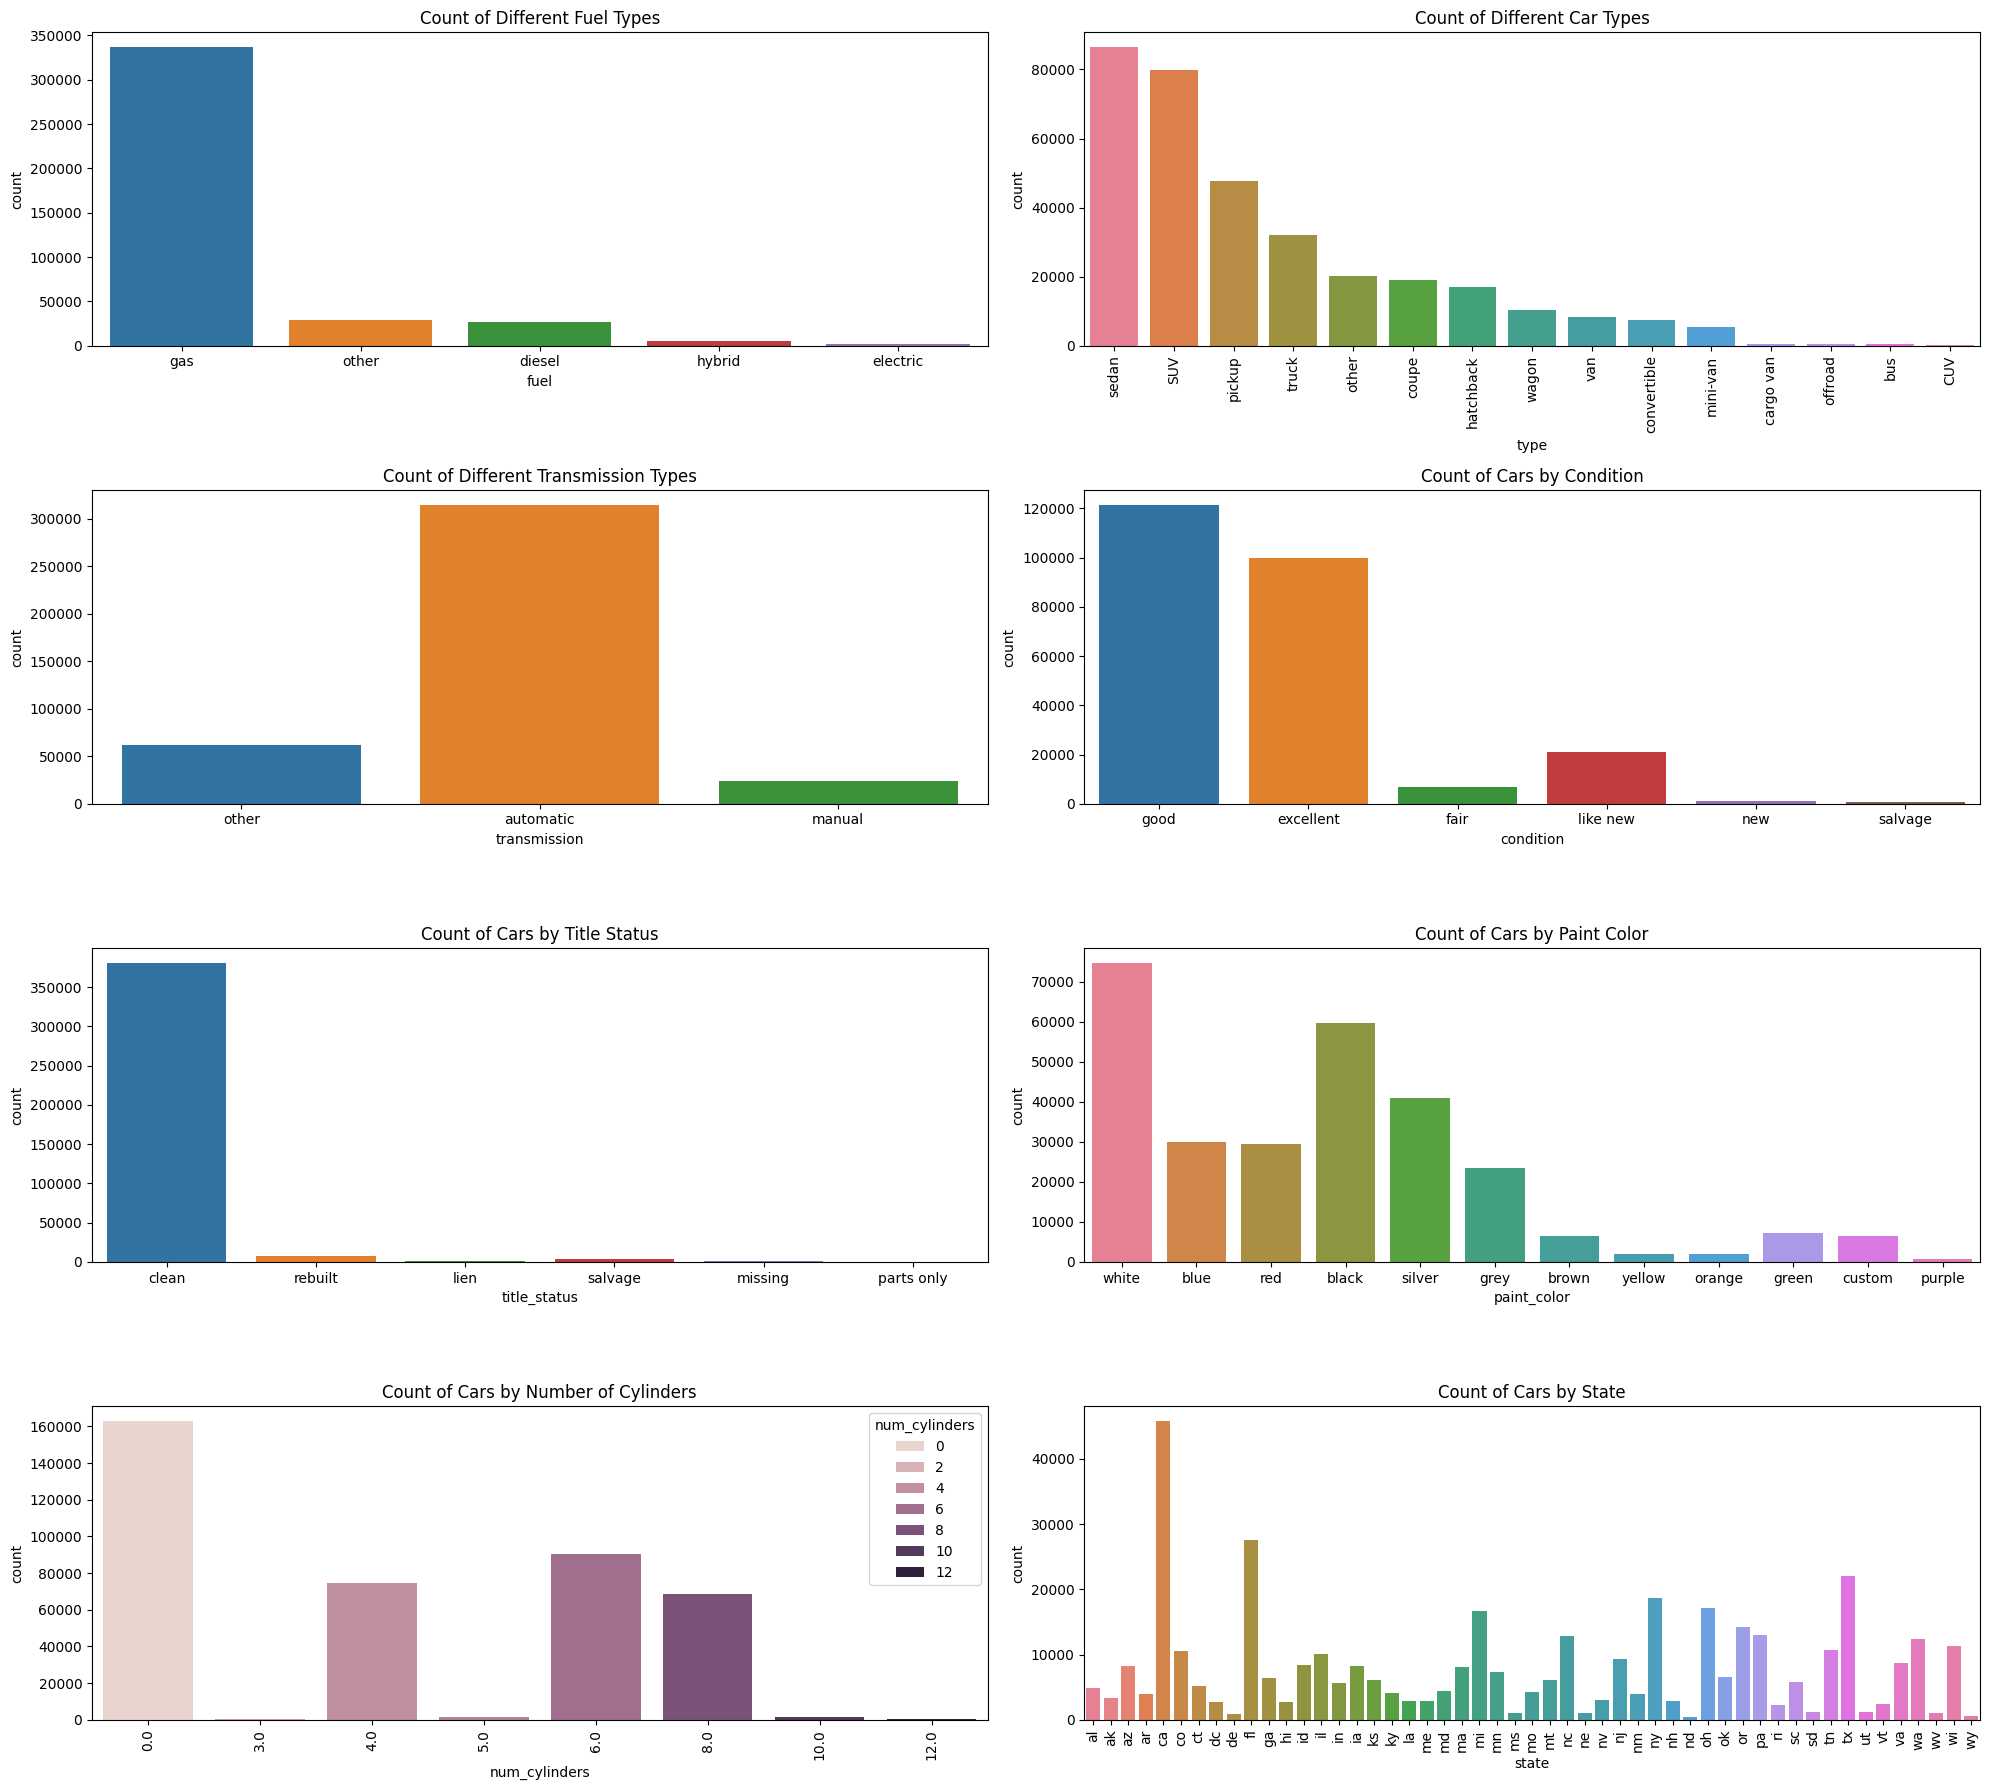

In [33]:
# Count plot visualization code for Categorical Variable
# Create a 4x2 subplot
plt.figure(figsize=(20,18))

# Subplot 1: Count of different Fuel Types
plt.subplot(4,2,1)
sns.countplot(data=vehicles_df, x='fuel', hue='fuel')
plt.title("Count of Different Fuel Types")

# Subplot 2: Count of different Car Types
plt.subplot(4,2,2)
type_df = vehicles_df['type'].value_counts()[:15].reset_index()
ax = sns.barplot(data=type_df, x='type', y='count', hue='type')
wrap_labels(ax, 10, len(type_df))
plt.title("Count of Different Car Types")
plt.xticks(rotation=90)

# Subplot 3: Count of different Transmission Types
plt.subplot(4,2,3)
sns.countplot(data=vehicles_df, x='transmission', hue='transmission')
plt.title("Count of Different Transmission Types")

# Subplot 4: Count Car Condition
plt.subplot(4,2,4)
sns.countplot(data=vehicles_df, x='condition', hue='condition')
plt.title("Count of Cars by Condition")

# Subplot 5: Count by title status
plt.subplot(4,2,5)
sns.countplot(data=vehicles_df, x='title_status', hue='title_status')
plt.title("Count of Cars by Title Status")

# Subplot 6: Count by Paint Color
plt.subplot(4,2,6)
sns.countplot(data=vehicles_df, x='paint_color', hue='paint_color')
plt.title("Count of Cars by Paint Color")

# Subplot 7: Count by Cylinders
plt.subplot(4,2,7)
sns.countplot(data=vehicles_df, x='num_cylinders', hue='num_cylinders')
plt.title("Count of Cars by Number of Cylinders")
plt.xticks(rotation=90)

# Subplot 8: Count by state
plt.subplot(4,2,8)
sns.countplot(data=vehicles_df, x='state', hue='state')
plt.title("Count of Cars by State")
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('images/count_plot_by_category_features.png')
plt.show()

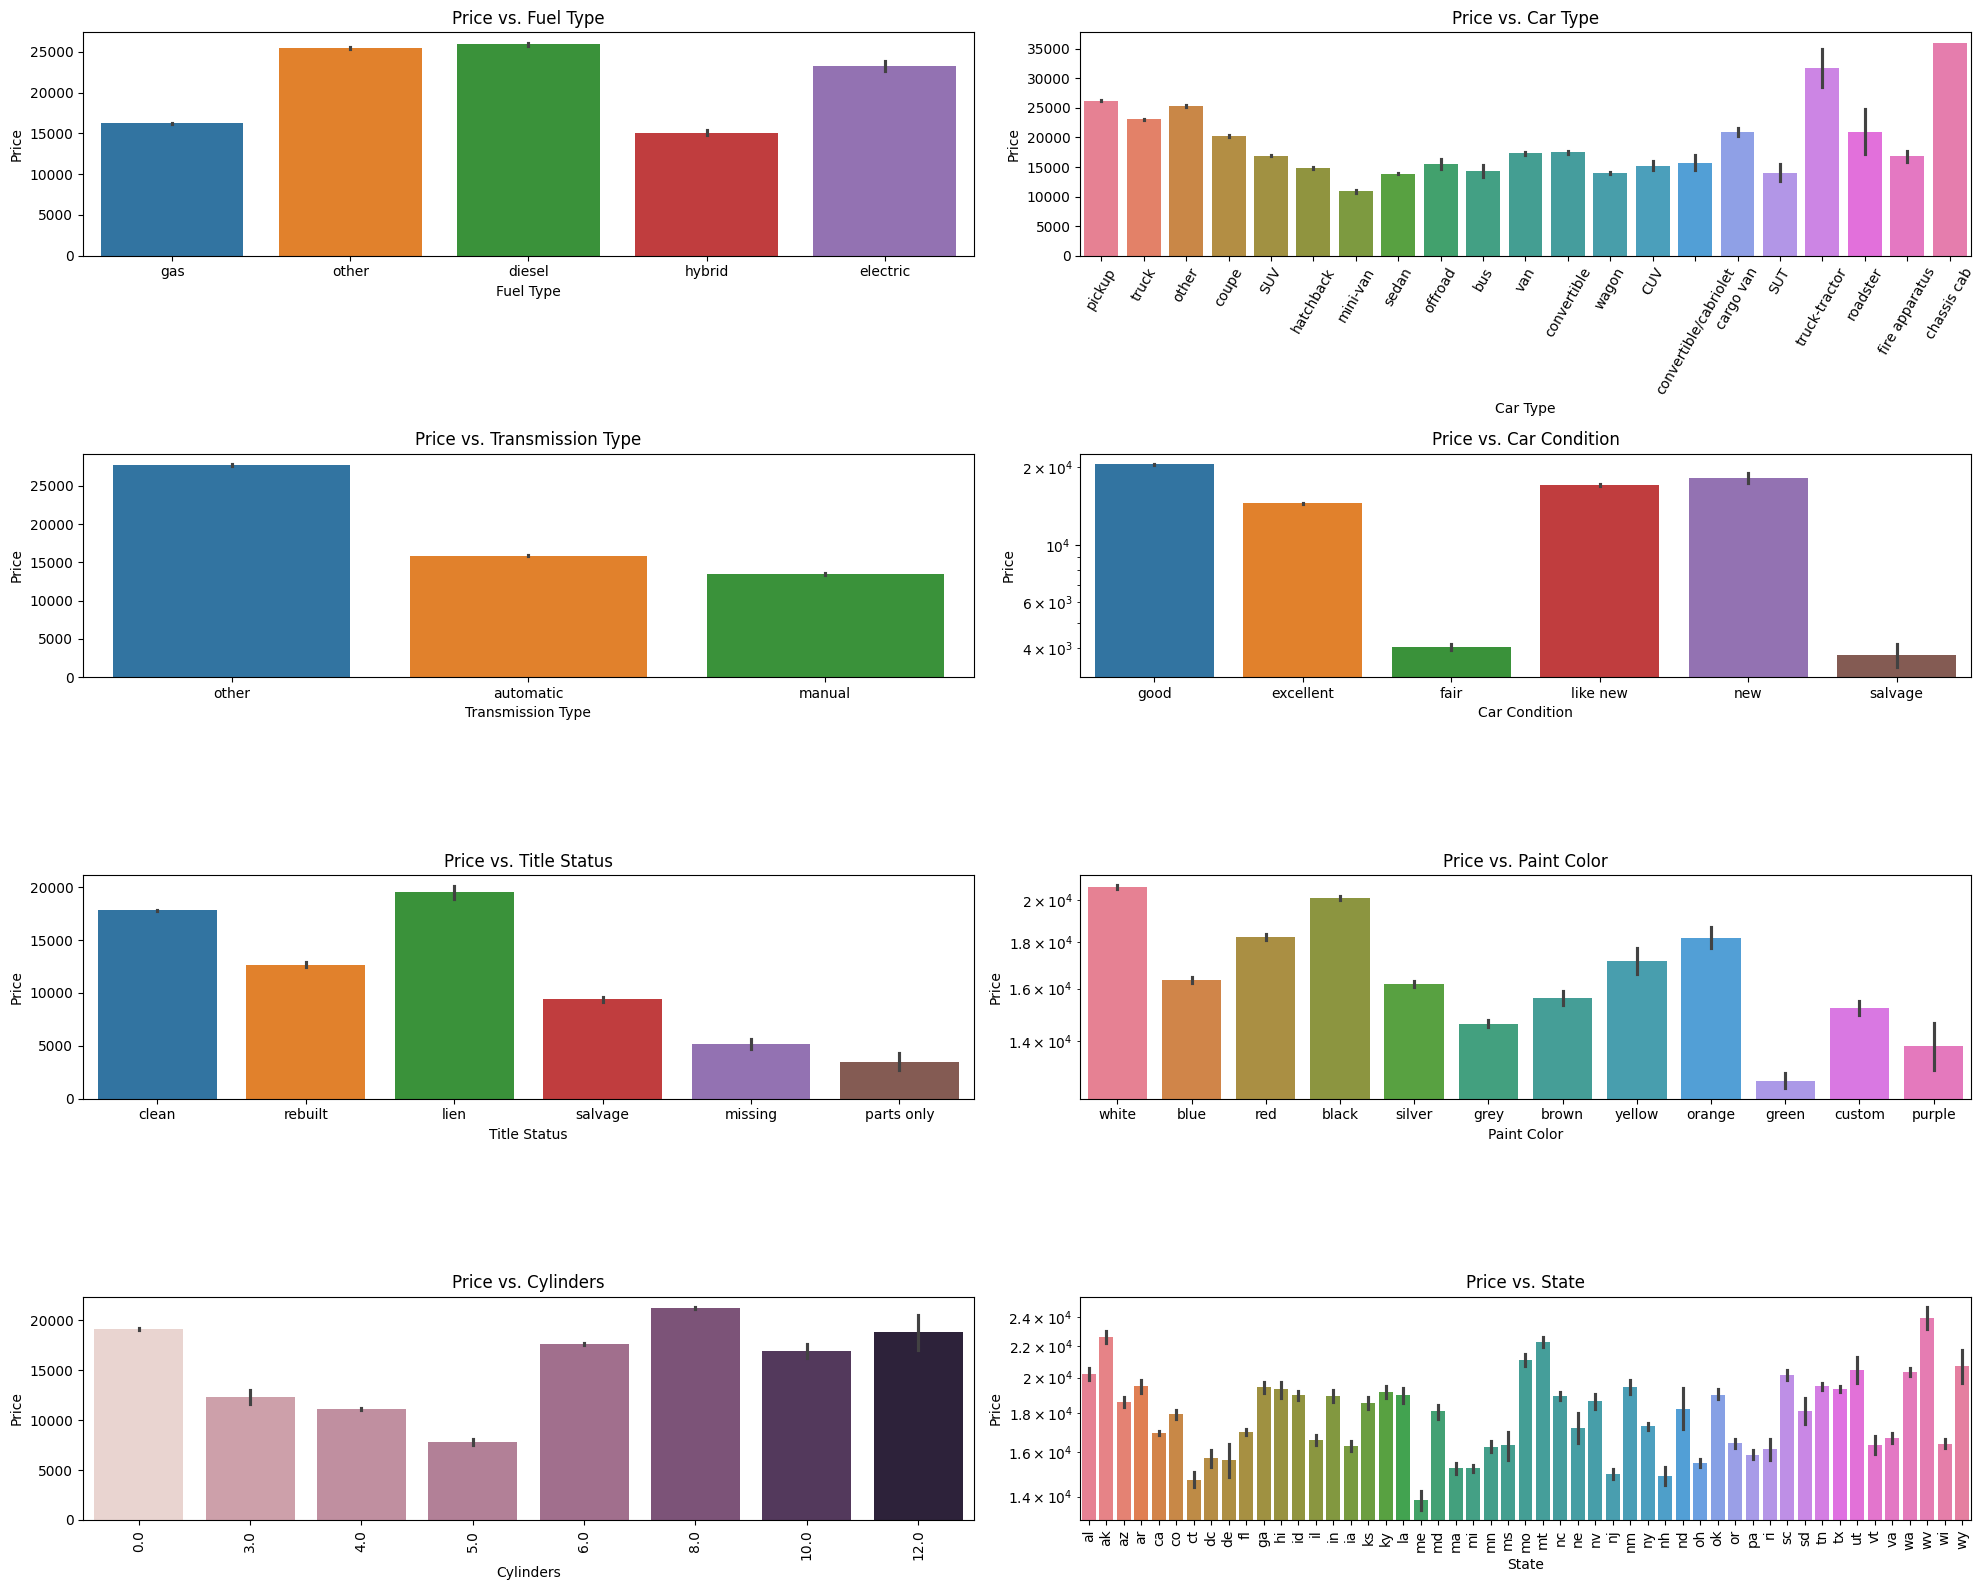

In [34]:
# Barplot visualization code for categorical variable vs target variable
# Create a 4x2 subplot
plt.figure(figsize=(20,16))

# Subplot 1: Barplot for Price vs. Fuel Type
plt.subplot(4,2,1)
sns.barplot(data=vehicles_df, x='fuel', y='price', hue='fuel')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.title('Price vs. Fuel Type')

# Subplot 2: Barplot for Price vs. Seller_Type
plt.subplot(4,2,2)
type_df = vehicles_df['type'].value_counts()
ax = sns.barplot(data=vehicles_df, x='type', y='price', hue='type')
wrap_labels(ax, 20, len(type_df))
plt.xticks(rotation=60)
plt.xlabel('Car Type')
plt.ylabel('Price')
plt.title('Price vs. Car Type')

# Subplot 3: Barplot for Price vs. Transmission
plt.subplot(4,2,3)
sns.barplot(data=vehicles_df, x='transmission', y='price', hue='transmission')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.title('Price vs. Transmission Type')

# Subplot 4: Barplot for Price vs. Condition
plt.subplot(4,2,4)
ax1 = sns.barplot(data=vehicles_df, x='condition', y='price', hue='condition')
ax1.set_yscale('log')
plt.xlabel('Car Condition')
plt.ylabel('Price')
plt.title('Price vs. Car Condition')

# Subplot 5: Count by title status
plt.subplot(4,2,5)
sns.barplot(data=vehicles_df, x='title_status', y='price', hue='title_status')
plt.xlabel('Title Status')
plt.ylabel('Price')
plt.title("Price vs. Title Status")

# Subplot 6: Count by Paint Color
plt.subplot(4,2,6)
ax2 = sns.barplot(data=vehicles_df, x='paint_color', y='price', hue='paint_color')
ax2.set_yscale('log')
plt.xlabel('Paint Color')
plt.ylabel('Price')
plt.title("Price vs. Paint Color")

# Subplot 7: Count by Cylinders
plt.subplot(4,2,7)
sns.barplot(data=vehicles_df, x='num_cylinders', y='price', hue='num_cylinders')
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.title("Price vs. Cylinders")
plt.legend().set_visible(False)
plt.xticks(rotation=90)

# Subplot 8: Count by state
plt.subplot(4,2,8)
ax3 = sns.barplot(data=vehicles_df, x='state', y='price', hue='state')
ax3.set_yscale('log')
plt.xlabel('State')
plt.ylabel('Price')
plt.title("Price vs. State")
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('images/price_vs_category_features.png')
plt.show()

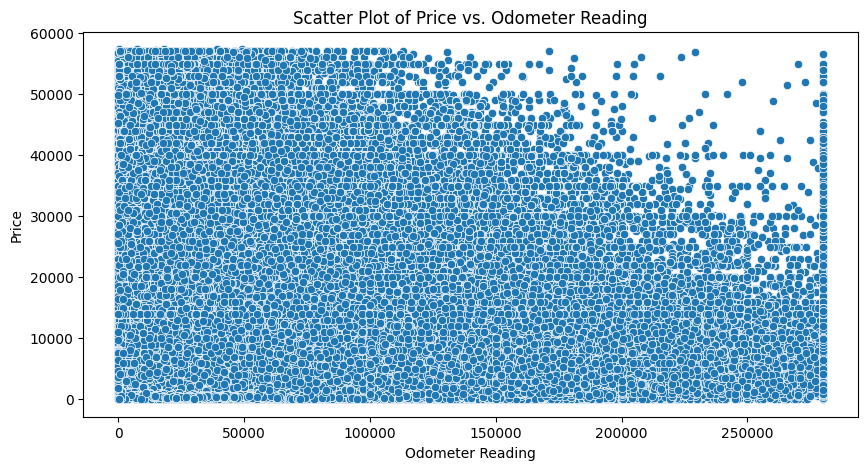

In [35]:
# Scatter plot visualization code for Odometer vs Price
# Set the figure size for the plot
plt.figure(figsize=(10,5))

# Create a scatter plot to visualize the relationship between Odometer and Price
ax4 = sns.scatterplot(data=vehicles_df, x='odometer', y='price')
# ax4.set_yscale('log')
# Set labels for the x and y axes
plt.xlabel('Odometer Reading')
plt.ylabel('Price')

# Add a title to the plot
plt.title('Scatter Plot of Price vs. Odometer Reading')

# Display the plot
plt.savefig('images/price_vs_odometer_scatter.png')
plt.show()

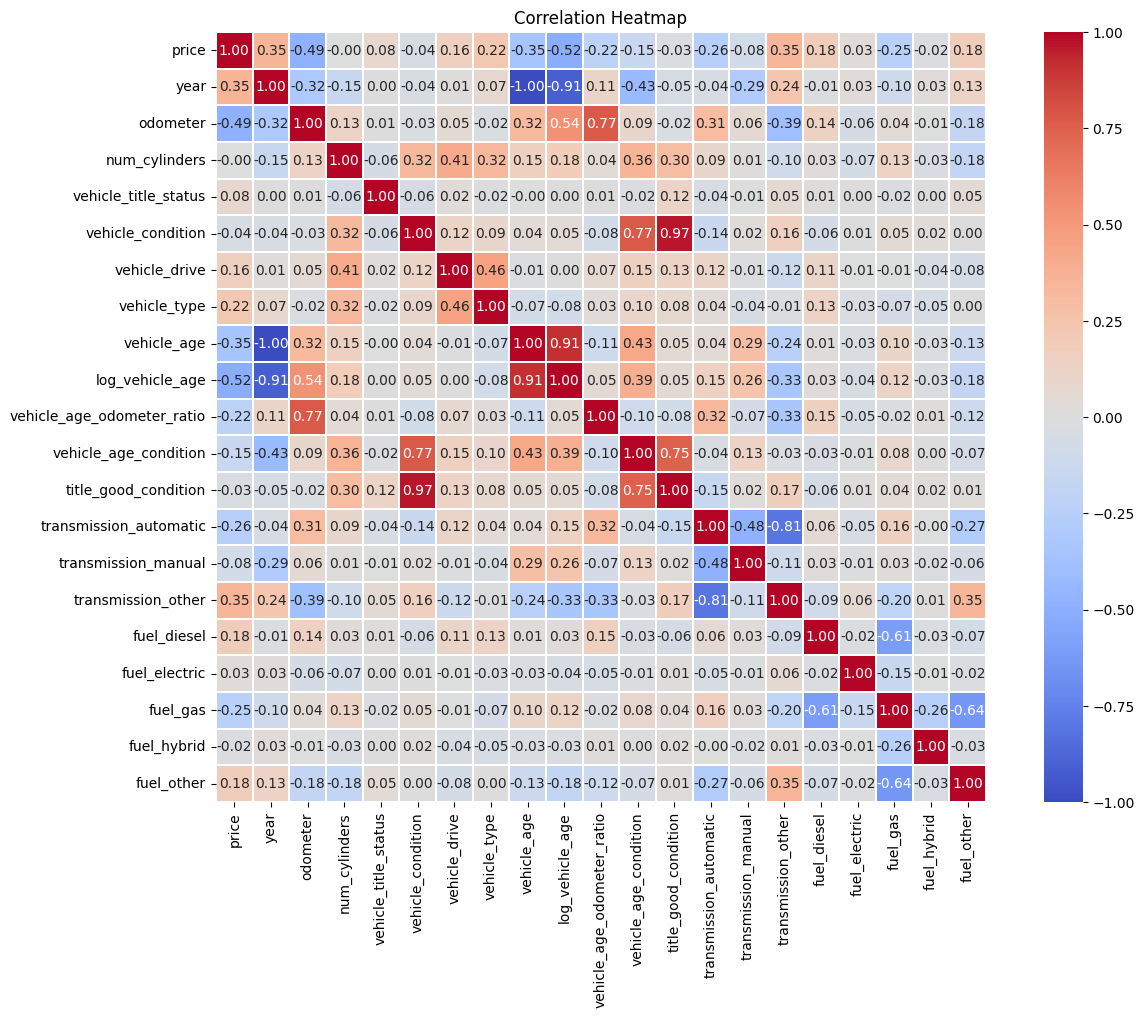

In [36]:
# Correlation Heatmap visualization code
# Set the size of the plot
plt.figure(figsize=(15, 10))

# Create a heatmap of the correlation matrix with annotations
numeric_df = vehicles_df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), annot=True, linewidths=0.1, fmt='.2f', square=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.savefig('images/features_heatmap.png')
plt.show()

### Summary of Data Visualization

* Ford, Chevrolet, Toyata are the top selling cars in the order.
* Ford F-150 is top selling model of the car.
* Most numbers of car were sold for the year 2018.
* Most important car features which are highly corrleated with most number of cars are as follows:
    * Most Valued Fuel Type: Gas
    * Most Valued Vehicle Type: Sedan
    * Most Valued Transmission: Automatic
    * Most Valued Condition: Good
    * Most Valued Title Status: Clean
    * Most Valued Color: White
    * Most Valued Cyclinders: Zero cylinders (Electric or Hydrogen fuel vehicles)
    * Top car seeling state: CA
* Most important car features which are highly corrleated with price of cars are as follows:
    * Fuel Type: Diesel and Other(Electric or Hydrogen Fuel)
    * Vehicle Type: Chasis-cab
    * Transmission Type: Other Type Transmission
    * Condition: Good
    * Title Status: Lien
    * Vehicle Color: White
    * Cyclinder configuration: 8 Cyclinders
    * State: West Virginia
* Scatter plot between odometer reading and price indicates that vehicle with lower odometer reading are sold at higher price.
* Correlation heatmap indicates that price is highly ngeatively correlated with vehicle age and odometer reading.

<h3>2.3 Data Cleaning/Transformation</h3>

In [37]:
# Apply Iterative Imputation for price column
# Root cause for R2 score 1.0
# def apply_IterativeImputer_price():
#     vehicles_df['price_impute'] = vehicles_df['price'].replace(0, np.nan)
#     imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),
#                            max_iter=5,
#                            random_state=42)
#     vehicles_df['price_impute'] = imputer.fit_transform(vehicles_df[[
#         'odometer', 'vehicle_age', 'log_vehicle_age', 'vehicle_age_odometer_ratio']])
#     return vehicles_df

# vehicles_df = apply_IterativeImputer_price()

# print(vehicles_df.shape)
# print(vehicles_df['price_impute'].isna().sum())

In [38]:
# Make a copy of dataset as a checkpoint
v_df = vehicles_df.copy()

In [39]:
v_df.head()

region    price  year manufacturer                     model  condition  \
0  auburn  33590.0  2014          gmc  sierra 1500 crew cab slt       good   
1  auburn  22590.0  2010    chevrolet            silverado 1500       good   
2  auburn  39590.0  2020    chevrolet       silverado 1500 crew       good   
3  auburn  30990.0  2017       toyota      tundra double cab sr       good   
4  auburn  15000.0  2013         ford                 f-150 xlt  excellent   

     cylinders fuel  odometer title_status  ... vehicle_age_condition  \
0  8 cylinders  gas   57923.0        clean  ...                  22.0   
1  8 cylinders  gas   71229.0        clean  ...                  30.0   
2  8 cylinders  gas   19160.0        clean  ...                  10.0   
3  8 cylinders  gas   41124.0        clean  ...                  16.0   
4  6 cylinders  gas  128000.0        clean  ...                  36.0   

  title_good_condition transmission_automatic transmission_manual  \
0                 10.0                    0.0                 0.0   
1                 10.0                    0.0                 0.0   
2                 10.0                    0.0                 0.0   
3                 10.0                    0.0                 0.0   
4                 15.0                    1.0                 0.0   

  transmission_other fuel_diesel  fuel_electric  fuel_gas  fuel_hybrid  \
0                1.0         0.0            0.0       1.0          0.0   
1                1.0         0.0            0.0       1.0          0.0   
2                1.0         0.0            0.0       1.0          0.0   
3                1.0         0.0            0.0       1.0          0.0   
4                0.0         0.0            0.0       1.0          0.0   

   fuel_other  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 34 columns]

In [40]:
# Get electric vehicles
v_electric = v_df[v_df['fuel'] == 'electric']
v_electric['cylinders'].unique()

<StringArray>
[<NA>, '4 cylinders', 'other', '8 cylinders', '6 cylinders', '3 cylinders']
Length: 6, dtype: string

In [41]:
# Encode category columns based on JamesSteinEncoder and using RandomForestRegressor
def encode_cat_features(v, feature, target):
    X = v[[feature]]
    y = v[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build pipeline
    pipeline = Pipeline(steps=[
        ('encoder', JamesSteinEncoder(cols=feature)),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    v[f'{feature}_encoded'] = pipeline.predict(X)
    v[f'{feature}_encoded'].unique()
    
    return v

In [42]:
# Apply encoding for reamining category columns
v_df = encode_cat_features(v_df, 'region', 'price')
v_df = encode_cat_features(v_df, 'manufacturer', 'price')
v_df = encode_cat_features(v_df, 'model', 'price')
v_df = encode_cat_features(v_df, 'paint_color', 'price')
v_df = encode_cat_features(v_df, 'state', 'price')

In [43]:
# Apply IterativeImputer and RandomForestRegressor for cylinders
def apply_IterativeImputer_cylinders(col):
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),
                           max_iter=10,
                           random_state=42)
    v_df[col] = imputer.fit_transform(v_df[['manufacturer_encoded','model_encoded', 'vehicle_type', 'num_cylinders']])
    return v_df

v_df = apply_IterativeImputer_cylinders('num_cylinders')

In [44]:
missing_values_percent = find_missing_values_percentage(v_df)
missing_values_percent

manufacturer     2.719205
model            0.864035
condition       37.483707
cylinders       40.487269
fuel             0.559492
title_status     1.854921
transmission     0.380803
VIN             38.384626
drive           30.464515
type            16.154734
paint_color     29.479610
dtype: float64

In [45]:
# Drop unused columns after the transformation
def drop_not_useful_columns(v_df):
    cols = ['year', 'region', 'manufacturer', 'model', 'condition',
           'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
           'drive', 'type', 'paint_color', 'state']
    
    v_df_clean = v_df.drop(cols, axis=1)
    return v_df_clean

v_df_clean = drop_not_useful_columns(v_df)
v_df_clean.head()

# Make sure, we don't have any nan in the data
missing_values_percent = find_missing_values_percentage(v_df_clean)
missing_values_percent

Series([], dtype: float64)

In [46]:
v_df_clean.head()

price  odometer  num_cylinders  vehicle_title_status  vehicle_condition  \
0  33590.0   57923.0   21938.374907                   5.0                2.0   
1  22590.0   71229.0   18221.491349                   5.0                2.0   
2  39590.0   19160.0   18221.491349                   5.0                2.0   
3  30990.0   41124.0   16618.510294                   5.0                2.0   
4  15000.0  128000.0   19042.648083                   5.0                3.0   

   vehicle_drive  vehicle_type  vehicle_age  log_vehicle_age  \
0           -1.0           8.0         11.0         2.484907   
1           -1.0           8.0         15.0         2.772589   
2           -1.0           8.0          5.0         1.791759   
3           -1.0           8.0          8.0         2.197225   
4            1.0          10.0         12.0         2.564949   

   vehicle_age_odometer_ratio  ...  fuel_diesel  fuel_electric  fuel_gas  \
0                 5265.727273  ...          0.0            0.0       1.0   
1                 4748.600000  ...          0.0            0.0       1.0   
2                 3832.000000  ...          0.0            0.0       1.0   
3                 5140.500000  ...          0.0            0.0       1.0   
4                10666.666667  ...          0.0            0.0       1.0   

   fuel_hybrid  fuel_other  region_encoded  manufacturer_encoded  \
0          0.0         0.0    26917.856871          21938.374907   
1          0.0         0.0    26917.856871          18221.491349   
2          0.0         0.0    26917.856871          18221.491349   
3          0.0         0.0    26917.856871          16618.510294   
4          0.0         0.0    26917.856871          19042.648083   

   model_encoded  paint_color_encoded  state_encoded  
0   35228.121289         20701.200640   20202.941272  
1   22631.738779         16352.946248   20202.941272  
2   34443.794112         18291.064420   20202.941272  
3   34709.977550         18291.064420   20202.941272  
4   20057.528154         20135.601393   20202.941272  

[5 rows x 25 columns]

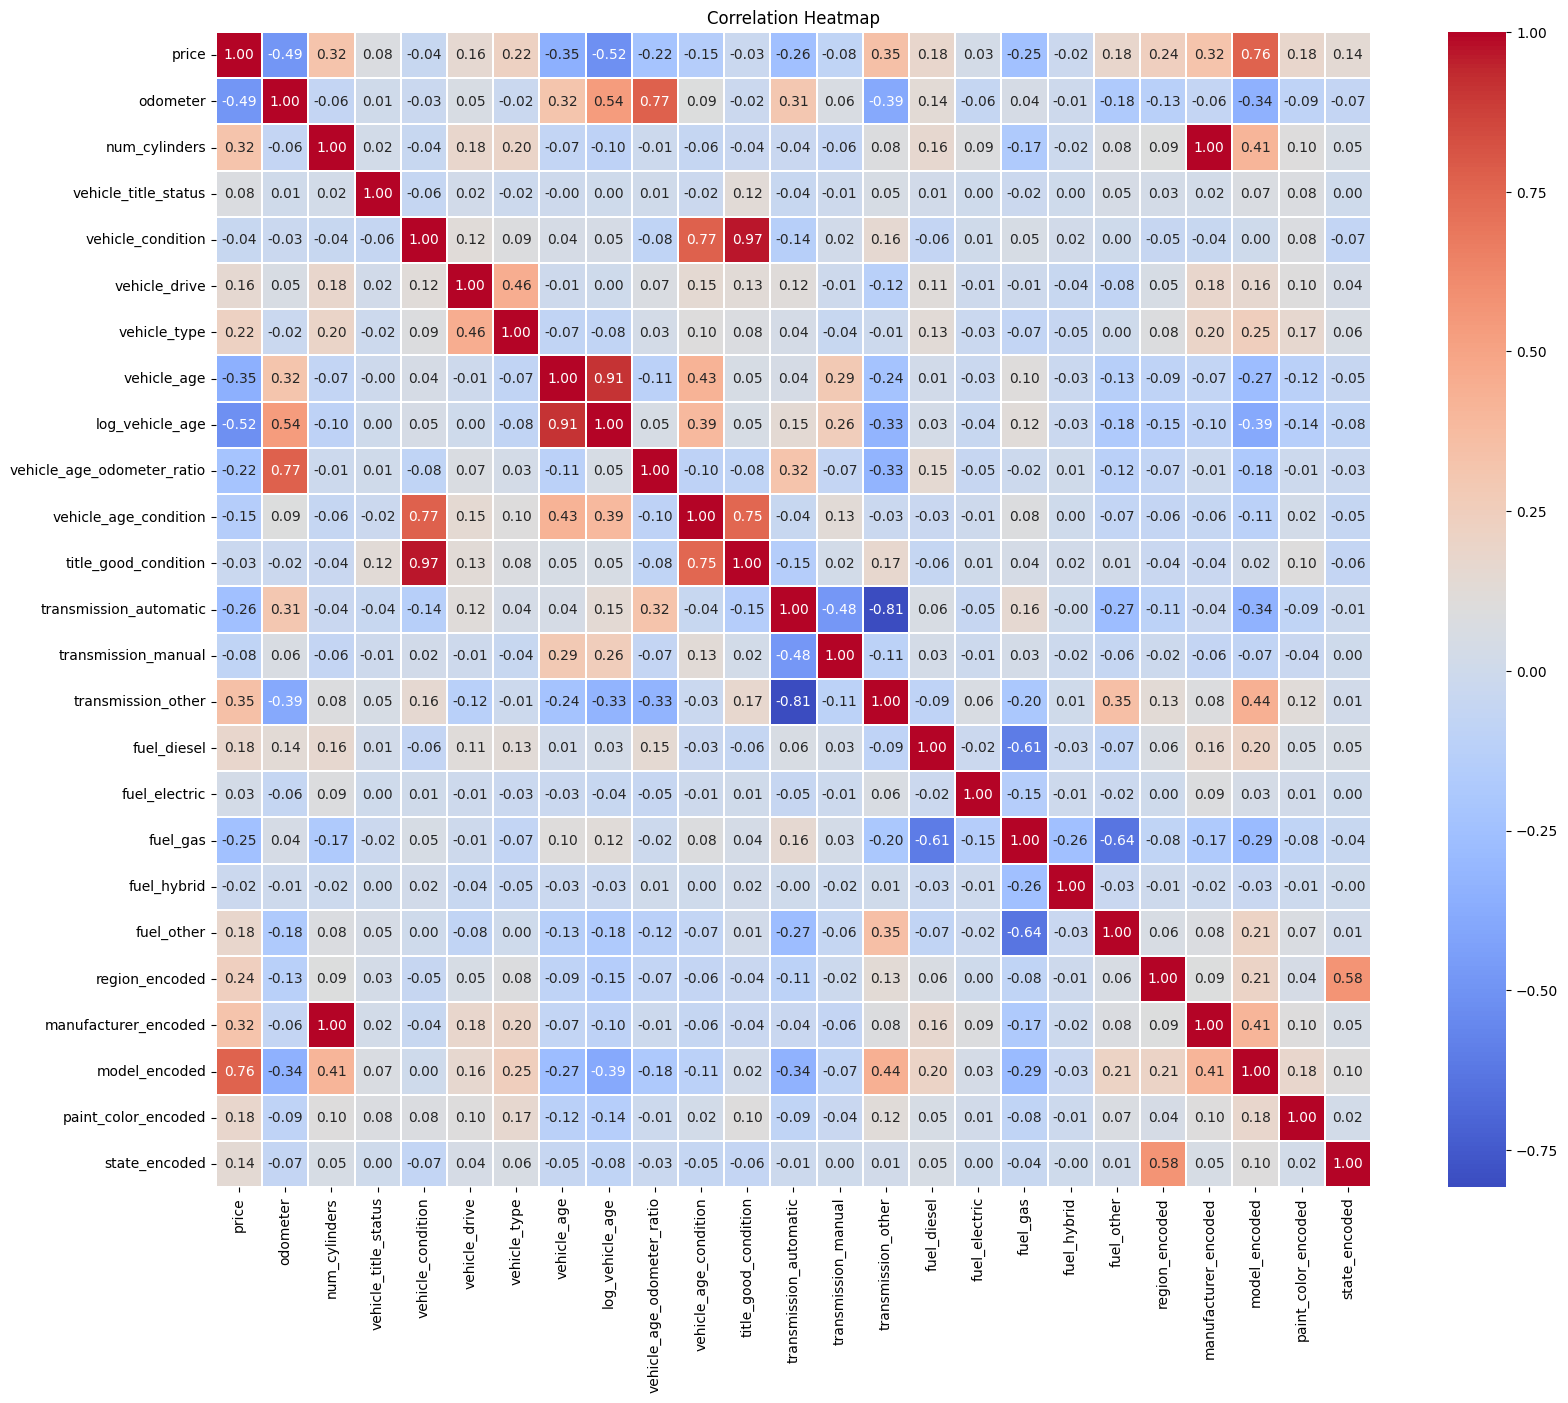

In [47]:
# Correlation Heatmap visualization code
# Set the size of the plot
plt.figure(figsize=(20, 15))

# Create a heatmap of the correlation matrix with annotations
corr_matrix = v_df_clean.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=0.1, fmt='.2f', square=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Heatmap")

# Display the plot
plt.savefig('images/corr_heatmap.png')
plt.show()

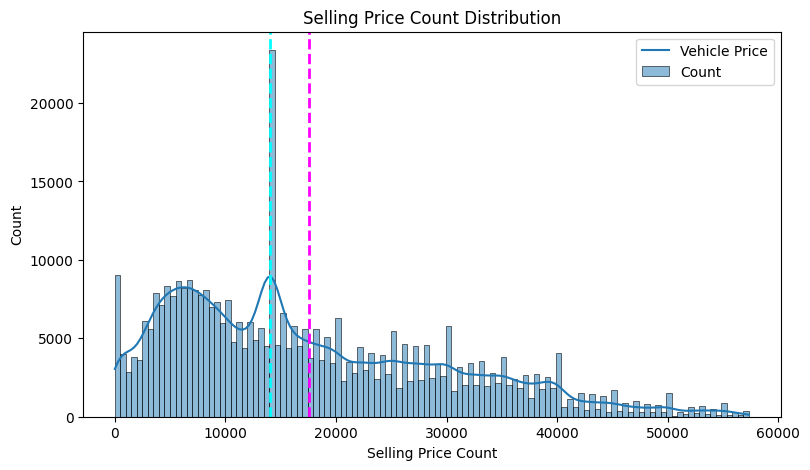

In [48]:
# Visualizing the distribution of the dependent variable - price
dependent_variable = ['price']
plt.figure(figsize=(9,5))
sns.histplot(v_df_clean[dependent_variable], kde=True)
plt.xlabel('Selling Price Count')
plt.title('Selling Price Count Distribution')
plt.legend(["Vehicle Price", "Count"])
plt.axvline(v_df_clean[dependent_variable[0]].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(v_df_clean[dependent_variable[0]].median(), color='cyan', linestyle='dashed', linewidth=2)
plt.savefig('images/vehicle_price_distribution.png')
plt.show()

### Summary of Data Cleaning and Transformation

* ~~Performed imputation using IterativeImputer with RandomForestRegressor for vehicle price column based on (odometer, price, vehicle_age, vehicle_age_odometer_ratio, vehicle_age_condition)~~ <b>Price imputation was causing data leakage.</b>
* Applied JamesSteinEncoder encoder with RandomForestRegressor for following features:
  * region
  * manufacturer
  * model
  * paint_color
  * state
* Performed imputation using IterativeImputer with RandomForestRegressor for following features:
  * manufacturer_encoded
  * model_encoded
  * vehicle_type
  * num_cylinders
* Dropped below redundant columns after applying imputation and encoding:
  * 'year', 'region', 'manufacturer', 'model', 'condition',
    'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
    'drive', 'type', 'paint_color', 'state'
* Some difference in mean and median of vehicle price indicates some level of variance in the dataset.

### 3. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [49]:
v_df_clean = shuffle(v_df_clean)
v_split_count = int(v_df_clean.shape[0] * 0.9)
data, data_valid = np.split(v_df_clean, [v_split_count], axis=0)
print(data.shape)
print(data_valid.shape)
X = data.drop('price', axis=1)
y = data['price']

(361131, 25)
(40126, 25)


/usr/local/Cellar/jupyterlab/4.3.5_1/libexec/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

odometer  num_cylinders  vehicle_title_status  vehicle_condition  \
261922   39441.0   22862.000398                   5.0               -1.0   
4490     24238.0   22862.000398                   5.0                2.0   
101080  111360.0   12898.577929                   5.0               -1.0   
53300   254099.0   19155.128685                   5.0                3.0   
8048     22086.0   18221.491349                   5.0               -1.0   

        vehicle_drive  vehicle_type  vehicle_age  log_vehicle_age  \
261922           -1.0           6.0          7.0         2.079442   
4490             -1.0           3.0          8.0         2.197225   
101080            0.0           3.0         15.0         2.772589   
53300             2.0           6.0         36.0         3.610918   
8048              0.0           3.0          6.0         1.945910   

        vehicle_age_odometer_ratio  vehicle_age_condition  ...  fuel_diesel  \
261922                 5634.428571                   -7.0  ...          0.0   
4490                   3029.750000                   16.0  ...          0.0   
101080                 7424.000000                  -15.0  ...          0.0   
53300                  7058.305556                  108.0  ...          0.0   
8048                   3681.000000                   -6.0  ...          0.0   

        fuel_electric  fuel_gas  fuel_hybrid  fuel_other  region_encoded  \
261922            0.0       1.0          0.0         0.0    15580.623383   
4490              0.0       1.0          0.0         0.0    21526.015327   
101080            0.0       1.0          0.0         0.0    17828.540779   
53300             0.0       1.0          0.0         0.0    16871.800917   
8048              0.0       1.0          0.0         0.0    20623.277001   

        manufacturer_encoded  model_encoded  paint_color_encoded  \
261922          22862.000398   21205.804474         16202.016137   
4490            22862.000398   30598.385092         20701.200640   
101080          12898.577929    8685.292408         16352.946248   
53300           19155.128685   19121.325663         20135.601393   
8048            18221.491349    9288.823960         18291.064420   

        state_encoded  
261922   17302.212170  
4490     20202.941272  
101080   16981.312343  
53300    16988.743294  
8048     22308.247315  

[5 rows x 24 columns]

In [51]:
len(X_train.columns)

24

In [52]:
# Find best model compexity
num_features = ['odometer', 'num_cylinders', 'vehicle_title_status',
       'vehicle_condition', 'vehicle_drive', 'vehicle_type',
       'log_vehicle_age', 'vehicle_age_odometer_ratio',
       'transmission_automatic', 'transmission_manual', 'transmission_other',
       'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'region_encoded', 'manufacturer_encoded',
       'model_encoded', 'paint_color_encoded', 'state_encoded']

def find_best_model_complexity(regressor, param_grid):
    preprocessor = ColumnTransformer(
        transformers=[
            ('transformer', Pipeline([ 
                ('scaler', RobustScaler()),
                ('poly', PolynomialFeatures())
            ]), num_features),
        ])
    
    pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('regressor', regressor)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid = param_grid,
        scoring = "neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        refit=True)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    cv_results = grid.cv_results_
    
    return best_model, cv_results

<h3>3.1 Linear Regression</h3>

In [53]:
# Linear Regression
start_time = time.time()
lr_param_grid = {
    'preprocessor__transformer__poly__degree': [1, 2], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True]
}
best_model_lr, cv_results_lr = find_best_model_complexity(LinearRegression(), lr_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 11.554600954055786


<h3>3.2 Ridge Regression</h3>

In [54]:
# Ridge Regression
start_time = time.time()
rcv_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__fit_intercept': [True, False],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'saga'],
    'regressor__tol': [1e-4, 1e-3, 1e-2]
}
best_model_rcv, cv_results_rcv = find_best_model_complexity(Ridge(), rcv_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 27.58338475227356


<h3>3.3 Lasso Regression</h3>

In [55]:
# Lasso Regression
start_time = time.time()
lcv_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__alpha': np.logspace(-6, 2, 10),
    'regressor__fit_intercept': [True, False],
    'regressor__warm_start': [True],
    'regressor__precompute': [True],
    'regressor__max_iter': [100000],
    'regressor__tol': [1e-3, 1e-2]
}
best_model_lcv, cv_results_lcv = find_best_model_complexity(Lasso(), lcv_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 5.981454133987427


<h3>3.4 ElasticNet Regression</h3>

In [56]:
## ElasticNet Regression
start_time = time.time()
ecv_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__selection': ['cyclic', 'random'],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'regressor__fit_intercept': [True, False],
    'regressor__warm_start': [True],
    'regressor__precompute': [True],
    'regressor__max_iter': [100000],
    'regressor__tol': [1e-4, 1e-3]
}
best_model_ecv, cv_results_ecv = find_best_model_complexity(ElasticNet(), ecv_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 29.424043893814087


<h3>3.5 XGBRegressor</h3>

In [57]:
## XGBoost Regression
start_time = time.time()
xg_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__random_state': [42],
    'regressor__objective': ['reg:squarederror'],
    # 'regressor__n_estimators': [100, 200], # Original
    'regressor__n_estimators': [500], # Tuned
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}
best_model_xg, cv_results_xg = find_best_model_complexity(XGBRegressor(), xg_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 85.15121507644653


<h3>3.6 HistGradientBoostingRegressor</h3>

In [58]:
## HistGradientBoostingRegressor Regression
start_time = time.time()
hgb_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__min_samples_leaf': [20, 50],
    'regressor__max_iter': [100, 200],
    'regressor__max_depth': [None, 5, 10],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__l2_regularization': [0.0, 1.0],
    'regressor__random_state': [42],
    # CatBoostRegressor
    # 'regressor__silent': [True],
    # 'regressor__iterations': [100, 200],
    # 'regressor__depth': [4, 6, 8],
    # 'regressor__learning_rate': [0.01, 0.1],
    # 'regressor__l2_leaf_reg': [1, 3, 5]
}
best_model_hgb, cv_results_hgb = find_best_model_complexity(HistGradientBoostingRegressor(), hgb_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 139.63767504692078


<h3>3.7 DecisionTreeRegressor</h3>

In [59]:
start_time = time.time()
dt_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__min_samples_split': [2, 10, 20],
    'regressor__min_samples_leaf': [1, 5, 10],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__ccp_alpha': [0.0, 0.01, 0.1],
    'regressor__random_state': [42]
}
best_model_dt, cv_results_dt = find_best_model_complexity(DecisionTreeRegressor(), dt_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

🕒 Duration (seconds): 183.7003309726715


<h3>3.8 RandomForestRegressor</h3>

In [60]:
start_time = time.time()
rf_param_grid = {
    'preprocessor__transformer__poly__degree': [1], 
    'preprocessor__transformer__poly__include_bias': [False],
    'preprocessor__transformer__poly__interaction_only': [True],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__n_estimators': [100],
    'regressor__warm_start': [True],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__random_state': [42],
    'regressor__max_depth': [None, 10, 20],
}
best_model_rf, cv_results_rf = find_best_model_complexity(RandomForestRegressor(), rf_param_grid)
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

/usr/local/Cellar/jupyterlab/4.3.5_1/libexec/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


🕒 Duration (seconds): 514.5237147808075


### Summary of Modeling

* Shuffled the clean dataset and divide into 2 parts (9:1 ratio)
  * First data set us used for model training and testing
  * Second data set would be never seen dataset and would be used to validate model.
* Split first data set into train and test set using scikit-learn train_test_split() method
* Trained 6 types of models based on different regression algorithms.
  * LinearRegression
  * Ridge Regression
  * Lasso Regression
  * ElasticNet
  * XGBoostRegressor
  * HistGradientBoostingRegressor
* Performed hyperparameters tuning of the models using GridSearchCV to perform cross-validation and evaulate best performing model.

### 4. Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [61]:
# Create a score dataframe
score = pd.DataFrame(index = ['MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 
                              'MAE Train', 'MAE Test', 'R2 Train', 'R2 Test', 'Adjusted R2 Train', 'Adjusted R2 Test'])

In [62]:
# Plot permutation importance 
def plot_permutation_importance(perm_dfs, model):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=perm_dfs.reset_index(), x='Features', y='Permutation Importance Mean', hue='Permutation Importance Std', palette='viridis')
    ax.set_yscale('log')
    plt.xlabel("Features")
    plt.xticks(rotation=75)
    plt.ylabel(f"Permutation Importance for {model} model")
    plt.savefig(f'images/perm_importance_{model}')

<b>Adjusted R² is a modified version of the R² (coefficient of determination) that accounts for the number of independent variables (features) in your model. It penalizes the addition of irrelevant features, unlike R² which always increases (or stays the same) when new features are added—even if they don’t improve the model.</b>

In [63]:
# Adjusted R2 score
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - ((1 - r2) * (n - 1)) / (n - n_features - 1)

In [131]:
# Function for model evaluation
mse_train_models = []
mse_test_models = []
rmse_train_models = []
rmse_test_models = []
mae_train_models = []
mae_test_models = []
r2_train_models = []
r2_test_models = []
adjusted_r2_train_models = []
adjusted_r2_test_models = []

def evaluate_models(best_model, model_name, y_test, X_test, y_train, X_train):

    '''
      Print evaluation metrics based on y_test and y_pred
      Plot actual vs predicted values
      Plot important features
      Returns a list of the model scores
    '''
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculating Evaluation Matrix
    mse_train = mean_squared_error(y_train_pred, y_train)
    mse_test = mean_squared_error(y_test_pred, y_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adjusted_r2_train = adjusted_r2_score(y_train, y_train_pred, X_train.shape[1])
    adjusted_r2_test = adjusted_r2_score(y_test, y_test_pred, X_test.shape[1])

    mse_train_models.append(mse_train)
    mse_test_models.append(mse_test)
    rmse_train_models.append(rmse_train)
    rmse_test_models.append(rmse_test)
    mae_train_models.append(mae_train)
    mae_test_models.append(mae_test)
    r2_train_models.append(r2_train)
    r2_test_models.append(r2_test)
    adjusted_r2_train_models.append(adjusted_r2_train)
    adjusted_r2_test_models.append(adjusted_r2_test)

    # Printing Evaluation Matrix
    print("MSE Train:" , mse_train)
    print("MSE Test:" , mse_test)
    print("RMSE Train:" ,rmse_train)
    print("RMSE Test:" ,rmse_test)
    print("MAE Train:" ,mae_train)
    print("MAE Test:" ,mae_test)
    print("R2 Train:", r2_train)
    print("R2 Test:", r2_test)
    print("Adjusted R2 Train:", adjusted_r2_train)
    print("Adjusted R2 Test:", adjusted_r2_test)

    # plot actual and predicted values
    plt.figure(figsize=(12,4))
    plt.plot(np.array(y_test_pred)[:100], linestyle='-', marker='^')
    plt.plot(np.float64((y_test)[:100]))
    plt.legend(["Predicted", "Actual"])
    plt.title('Actual and Predicted Selling Price', fontsize=12)
    plt.savefig(f'images/predicted_vs_actual_price_for_{model_name}')

    results = permutation_importance(best_model, X_test, y_test)
    perm_df = pd.DataFrame({
      'perm_importance_mean': results.importances_mean,
      'perm_importance_std': results.importances_std
    }, index=X.columns).sort_values(by='perm_importance_mean', ascending=False)
    
    perm_df = perm_df.reset_index()
    perm_df.columns = ['Features', 'Permutation Importance Mean', 'Permutation Importance Std']
    print('\n')
    print(tabulate(perm_df, headers='keys', tablefmt='github', showindex=False))
    
    # Feature importances
    plot_permutation_importance(perm_df, model_name)

    model_score = [mse_train, mse_test, rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test, adjusted_r2_train, adjusted_r2_test]
    return model_score

<h4>4.1 Evaluate LinearRegression model</h4>

MSE Train: 44414251.109892584
MSE Test: 43993262.174493834
RMSE Train: 6664.401781847534
RMSE Test: 6632.741678559013
MAE Train: 4331.176698014542
MAE Test: 4309.288467775843
R2 Train: 0.715692403862045
R2 Test: 0.7187060242170826
Adjusted R2 Train: 0.7156687836532125
Adjusted R2 Test: 0.718612521884477


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| odometer                   |                   13.7382     |                  0.0287751   |
| vehicle_age_odometer_ratio |                    7.34565    |                  0.0266451   |
| log_vehicle_age            |                    4.67262    |                  0.0316484   |
| model_encoded              |                    0.624517   |                  0.00252438  |
| fuel_gas                   |                    0.0534186  |                  0.000877565 |
| transmission_automatic     |     

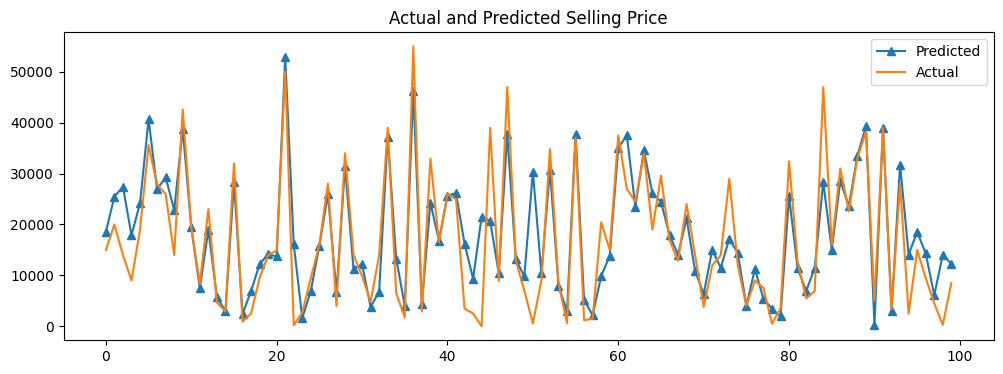

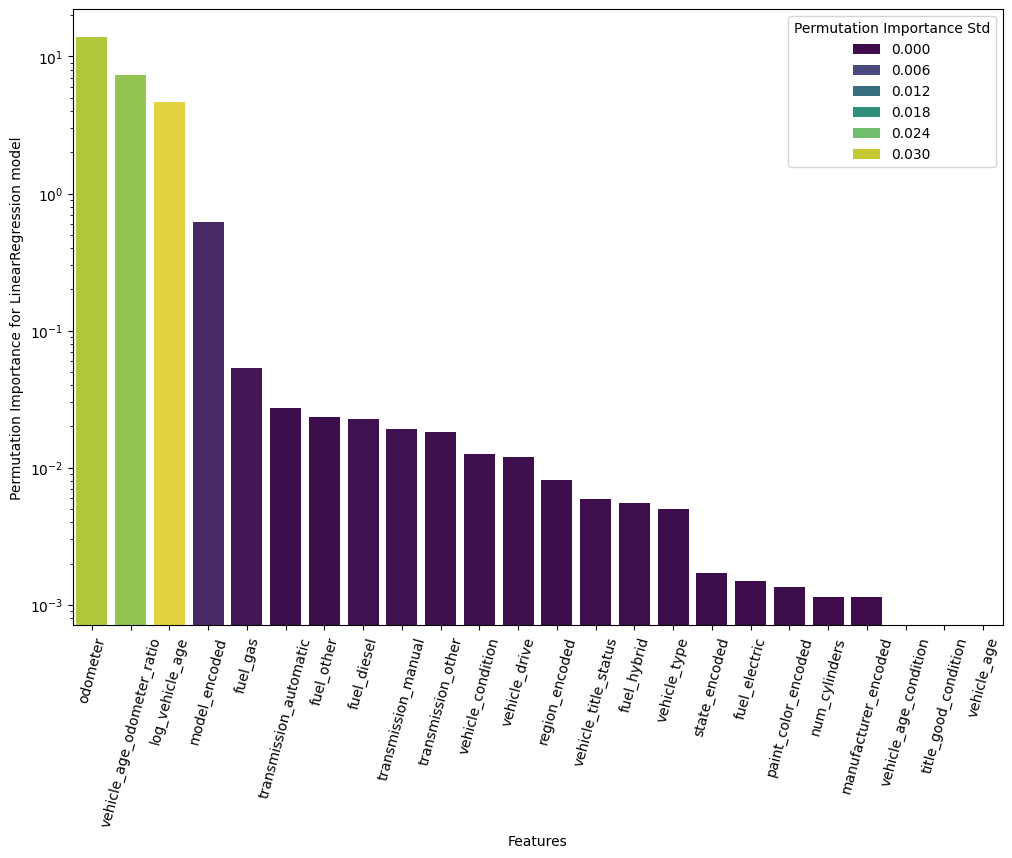

In [132]:
# Evaluate LinearRegression model
start_time = time.time()
linear_score = evaluate_models(best_model_lr, 'LinearRegression', y_test, X_test, y_train, X_train)
score['Linear Regressor'] = linear_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.2 Evaluate Ridge model</h4>

MSE Train: 49564786.43025924
MSE Test: 49127196.85019838
RMSE Train: 7040.22630532991
RMSE Test: 7009.079600789135
MAE Train: 4727.050395837671
MAE Test: 4706.868559135176
R2 Train: 0.6827224386107134
R2 Test: 0.6858795224993721
Adjusted R2 Train: 0.6826960792648511
Adjusted R2 Test: 0.685775108612499


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| model_encoded              |                   0.680882    |                  0.00432566  |
| odometer                   |                   0.251509    |                  0.00121751  |
| vehicle_age_odometer_ratio |                   0.0397267   |                  0.000320717 |
| log_vehicle_age            |                   0.0218542   |                  0.000310848 |
| transmission_other         |                   0.00926826  |                  0.000214973 |
| fuel_diesel                |       

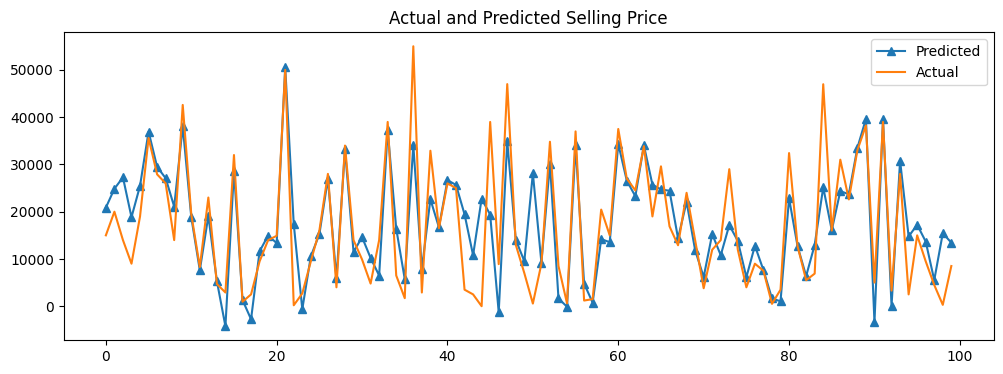

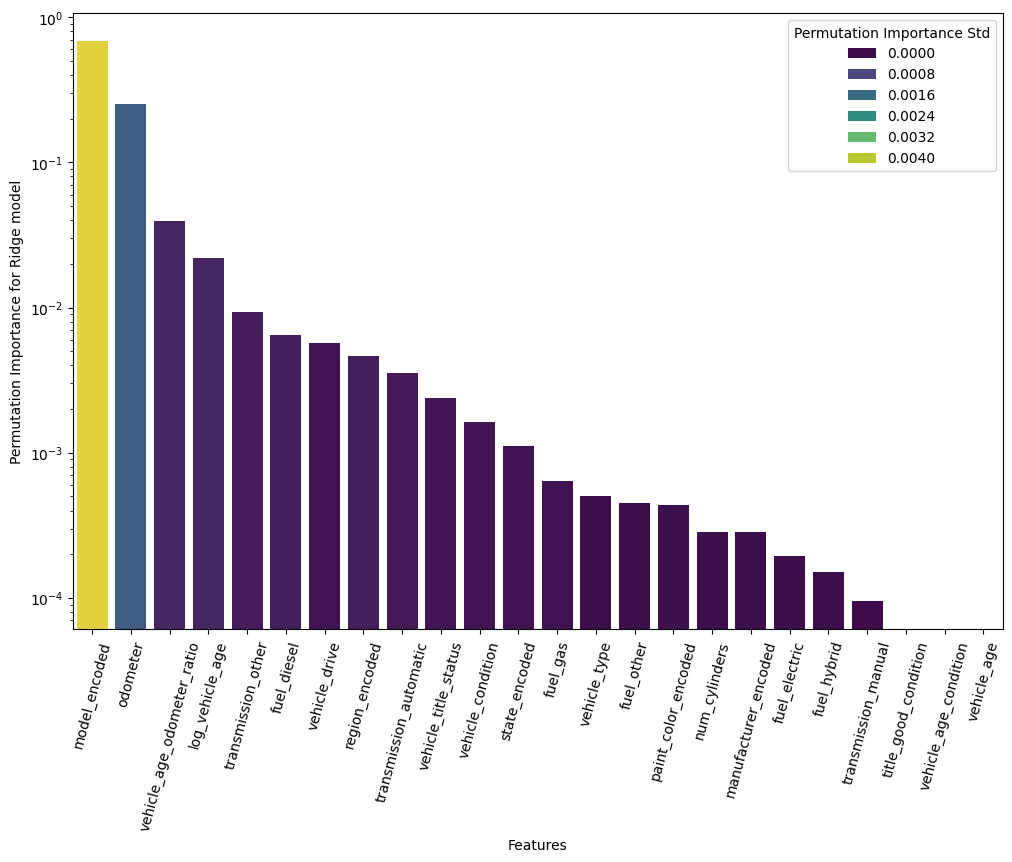

In [133]:
# Evaluate Ridge model
start_time = time.time()
ridge_score = evaluate_models(best_model_rcv, 'Ridge', y_test, X_test, y_train, X_train)
score['Ridge Regressor'] = ridge_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.3 Evaluate Lasso model</h4>

MSE Train: 49559609.64481494
MSE Test: 49121075.362276495
RMSE Train: 7039.858638127255
RMSE Test: 7008.642904462781
MAE Train: 4724.848828886777
MAE Test: 4704.857027057168
R2 Train: 0.6827555766100855
R2 Test: 0.6859186634402831
Adjusted R2 Train: 0.6827292200173205
Adjusted R2 Test: 0.6858142625638886


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| model_encoded              |                   0.685496    |                  0.00177957  |
| odometer                   |                   0.251115    |                  0.0007576   |
| vehicle_age_odometer_ratio |                   0.0398134   |                  0.000553736 |
| log_vehicle_age            |                   0.0217714   |                  0.000316489 |
| transmission_other         |                   0.00930959  |                  0.000215591 |
| num_cylinders              |    

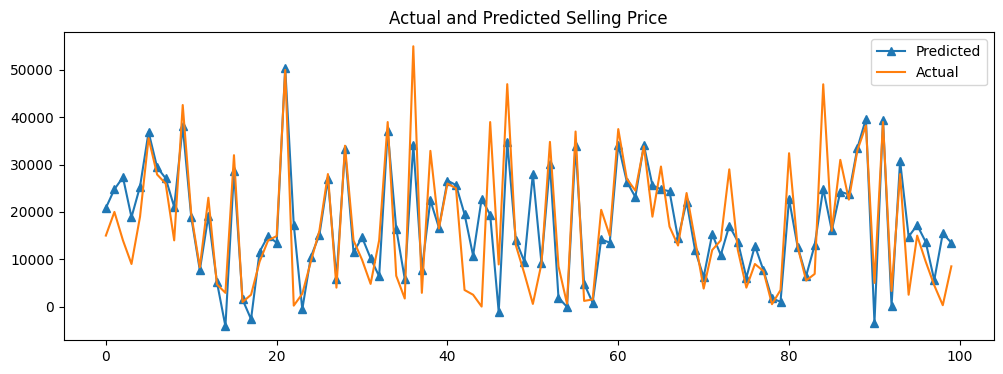

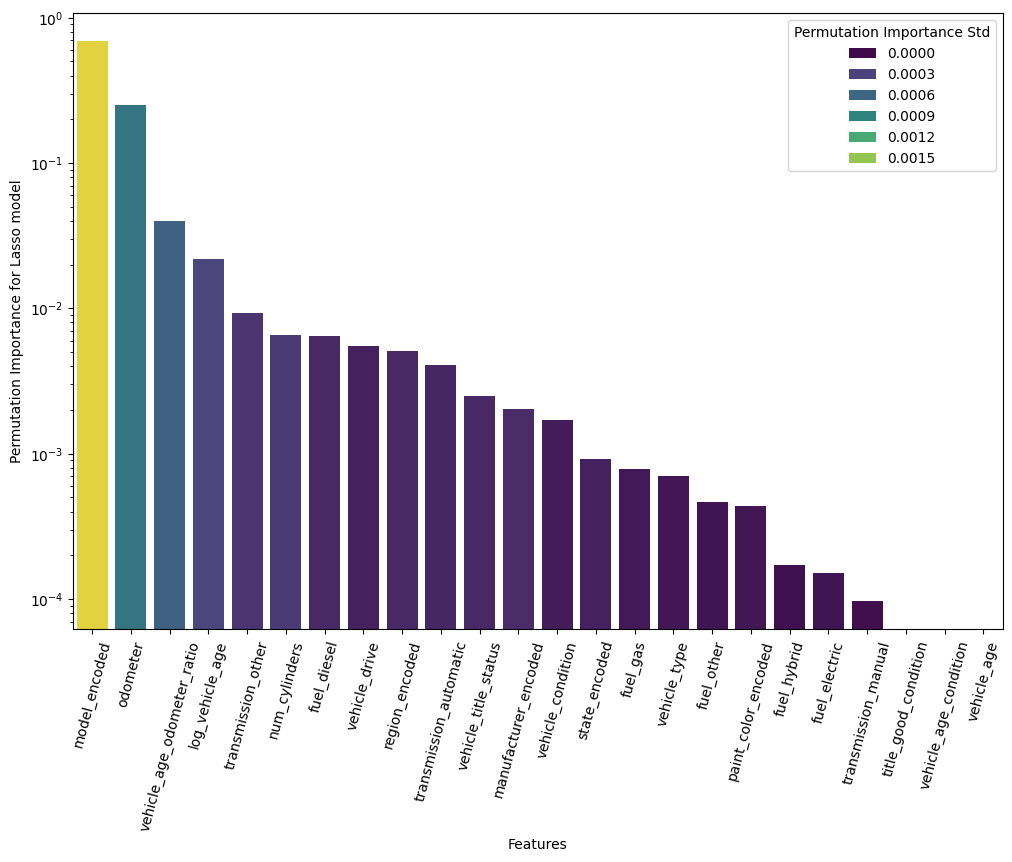

In [134]:
# Evaluate Lasso model
start_time = time.time()
lasso_score = evaluate_models(best_model_lcv, 'Lasso', y_test, X_test, y_train, X_train)
score['Lasso Regressor'] = lasso_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.4 Evaluate ElasticNet model</h4>

MSE Train: 49559673.03898146
MSE Test: 49121231.47417214
RMSE Train: 7039.863140642825
RMSE Test: 7008.654041552639
MAE Train: 4724.744480963577
MAE Test: 4704.759376906895
R2 Train: 0.6827551708069335
R2 Test: 0.68591766525707
Adjusted R2 Train: 0.6827288141804544
Adjusted R2 Test: 0.6858132640488787


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| model_encoded              |                   0.684045    |                  0.00529127  |
| odometer                   |                   0.251254    |                  0.00106667  |
| vehicle_age_odometer_ratio |                   0.0390155   |                  0.000627091 |
| log_vehicle_age            |                   0.021772    |                  0.000410054 |
| transmission_other         |                   0.00859643  |                  0.00021756  |
| fuel_diesel                |       

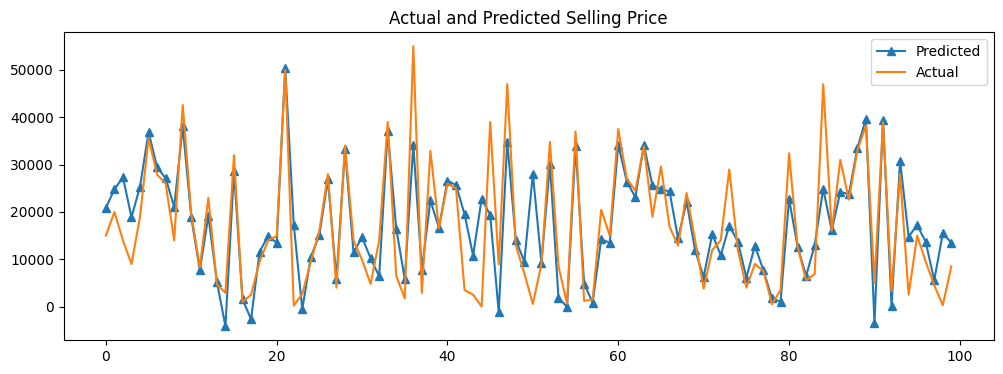

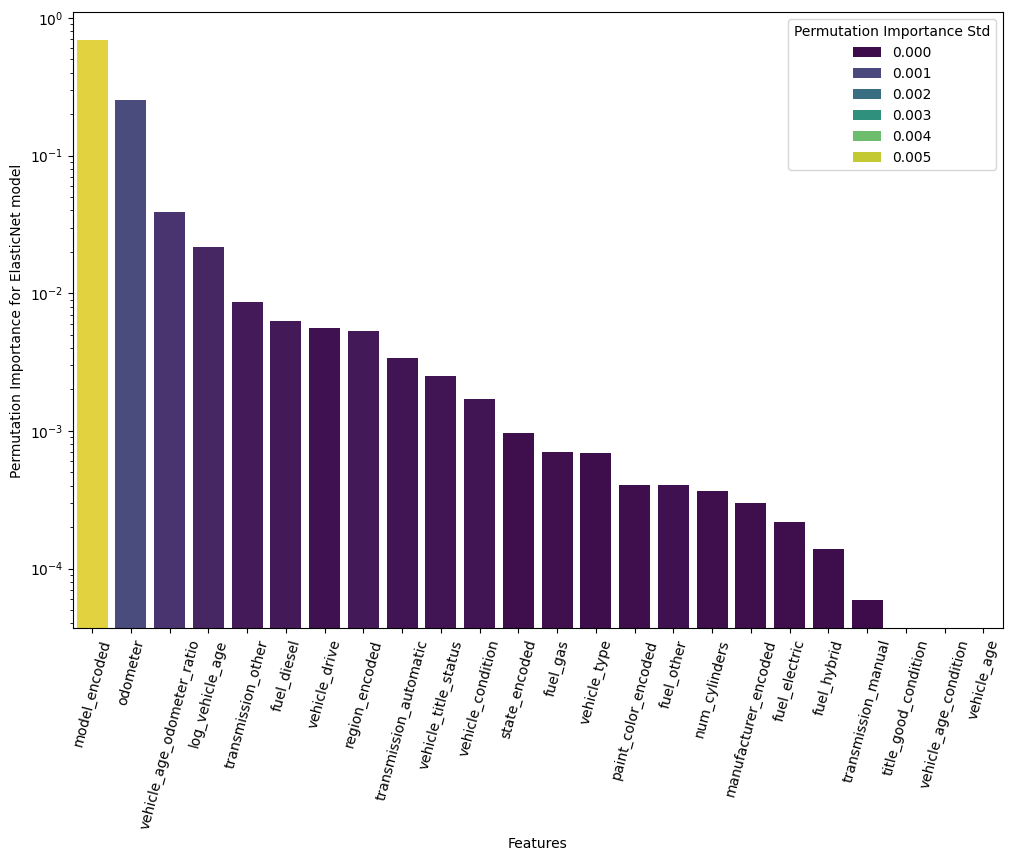

In [135]:
# Evaluate ElasticNet model
start_time = time.time()
elasticnet_score = evaluate_models(best_model_ecv, 'ElasticNet', y_test, X_test, y_train, X_train)
score['ElasticNet Regressor'] = elasticnet_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.5 Evaluate XGBRegressor model</h4>

MSE Train: 18275793.585982967
MSE Test: 23051603.45138221
RMSE Train: 4275.019717613355
RMSE Test: 4801.208540709537
MAE Train: 2654.962770222885
MAE Test: 2915.2360297060586
R2 Train: 0.883011717813543
R2 Test: 0.8526074934545331
Adjusted R2 Train: 0.8830019984543218
Adjusted R2 Test: 0.8525585000726726


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| model_encoded              |                   0.489446    |                  0.00274551  |
| log_vehicle_age            |                   0.239737    |                  0.00199207  |
| odometer                   |                   0.12097     |                  0.0015164   |
| vehicle_age_odometer_ratio |                   0.0631056   |                  0.000577247 |
| num_cylinders              |                   0.0492373   |                  0.000610908 |
| vehicle_condition          |    

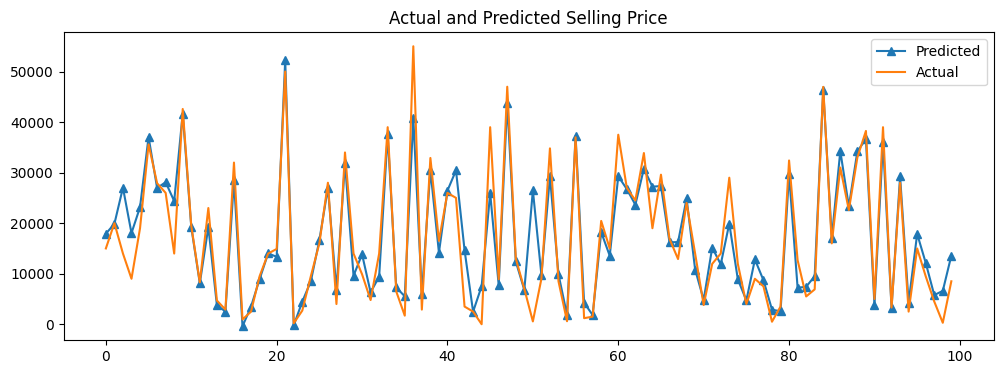

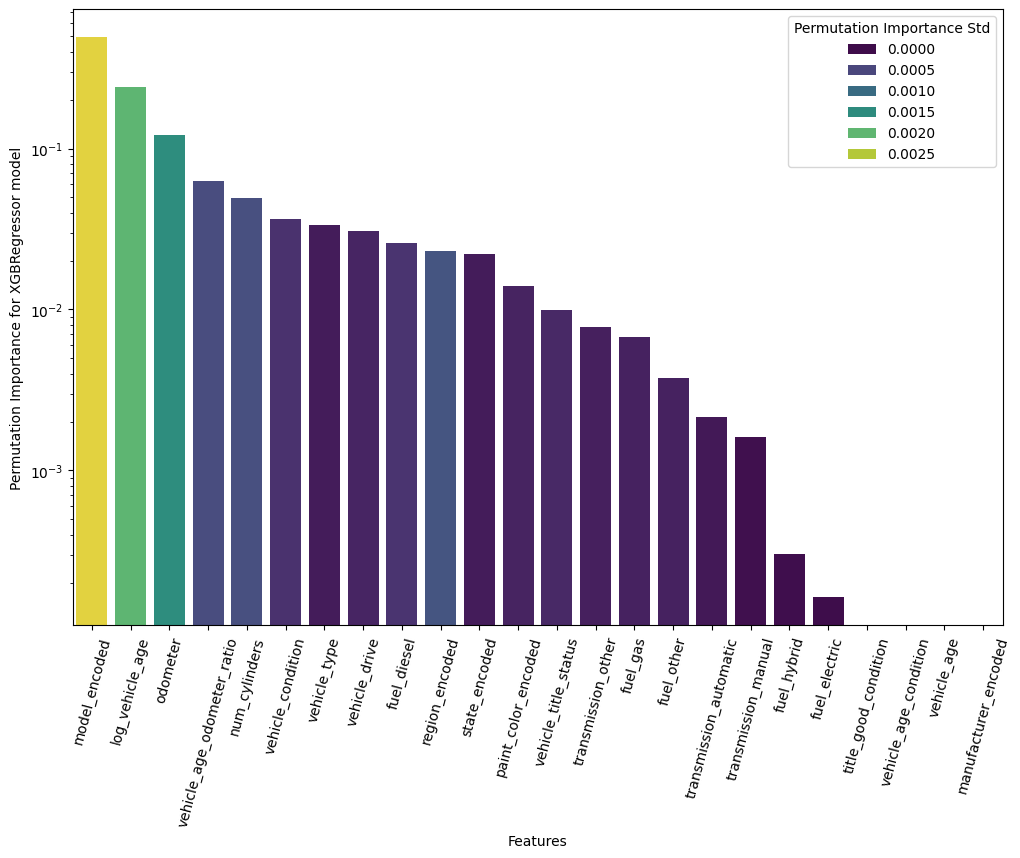

In [136]:
# Evaluate XGBRegressor model
start_time = time.time()
xgb_score = evaluate_models(best_model_xg, 'XGBRegressor', y_test, X_test, y_train, X_train)
score['XGBRegressor'] = xgb_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.6 Evaluate HistGradientBoostingRegressor model</h4>

MSE Train: 30499723.58484852
MSE Test: 31051074.42003866
RMSE Train: 5522.655483084974
RMSE Test: 5572.349093518698
MAE Train: 3450.957878953163
MAE Test: 3487.3114109941157
R2 Train: 0.8047630461262247
R2 Test: 0.8014586838025404
Adjusted R2 Train: 0.8047468258855947
Adjusted R2 Test: 0.8013926885172472


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| model_encoded              |                   0.591081    |                  0.00281472  |
| log_vehicle_age            |                   0.190352    |                  0.00121534  |
| odometer                   |                   0.0824128   |                  0.00121678  |
| vehicle_condition          |                   0.0272457   |                  0.000474749 |
| vehicle_drive              |                   0.0263857   |                  0.000537094 |
| fuel_diesel                |    

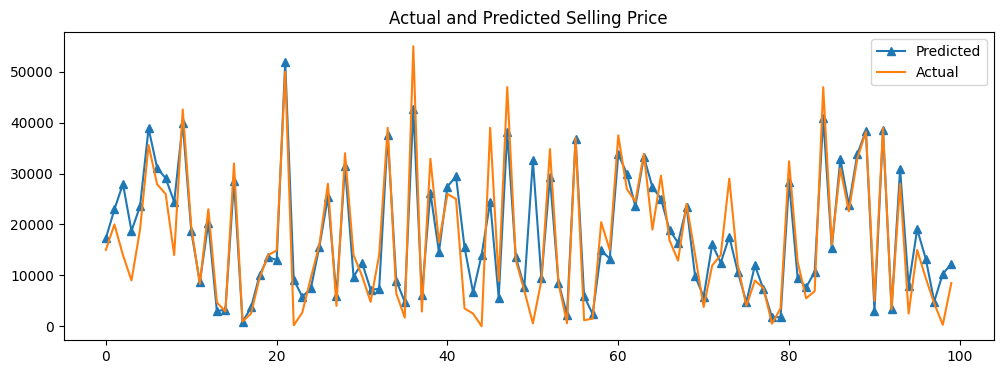

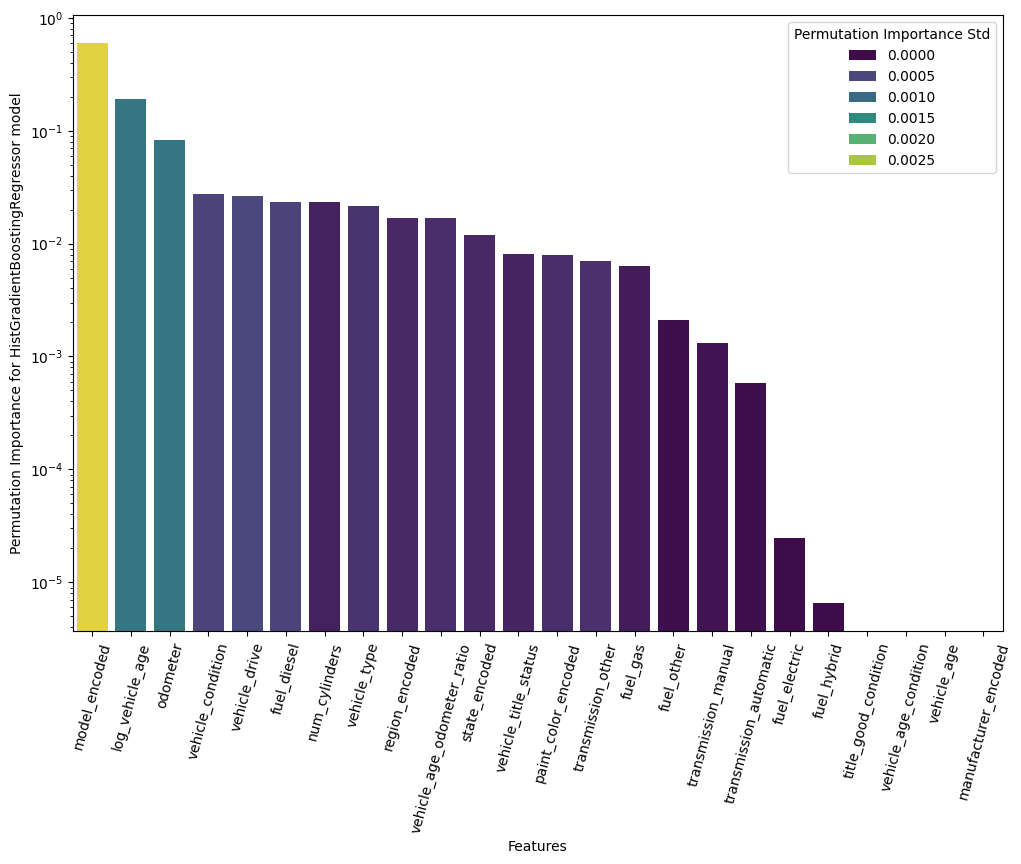

In [137]:
# Evaluate HistGradientBoostingRegressor model
start_time = time.time()
hgb_score = evaluate_models(best_model_hgb, 'HistGradientBoostingRegressor', y_test, X_test, y_train, X_train)
score['HistGradientBoosting Regressor'] = hgb_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.7 Evaluate DecisionTreeRegressor model</h4>

MSE Train: 15383714.194427473
MSE Test: 30893477.770545036
RMSE Train: 3922.207821422454
RMSE Test: 5558.19015242777
MAE Train: 2136.3982334297307
MAE Test: 3056.768595084595
R2 Train: 0.9015246977491682
R2 Test: 0.8024663605674571
Adjusted R2 Train: 0.9015165164440058
Adjusted R2 Test: 0.802400700234691
                      Features  Permutation Importance Mean  \
0                model_encoded                     0.825590   
1              log_vehicle_age                     0.398249   
2                     odometer                     0.227969   
3   vehicle_age_odometer_ratio                     0.101090   
4            vehicle_condition                     0.085325   
5                vehicle_drive                     0.071774   
6                 vehicle_type                     0.062401   
7         manufacturer_encoded                     0.059138   
8                num_cylinders                     0.048797   
9                  fuel_diesel                     0.043289   
1

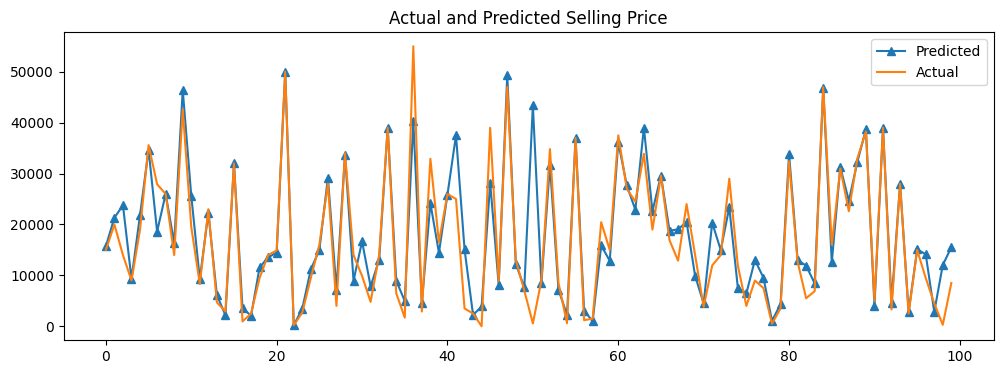

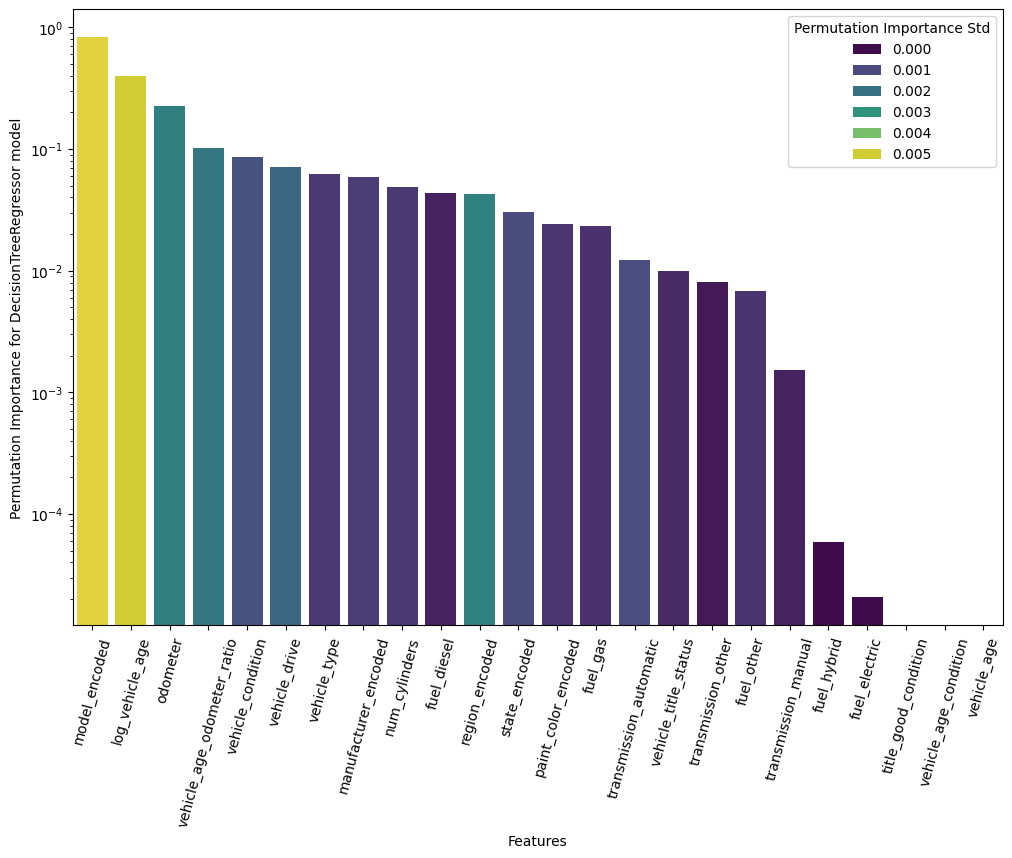

In [124]:
# Evaluate DecisionTreeRegressor model
start_time = time.time()
dt_score = evaluate_models(best_model_dt, 'DecisionTreeRegressor', y_test, X_test, y_train, X_train)
score['DecisionTreeRegressor'] = dt_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

<h4>4.8 Evaluate RandomForestRegressor model</h4>

MSE Train: 2666361.0889052227
MSE Test: 17435820.399513923
RMSE Train: 1632.8995954758586
RMSE Test: 4175.622157177769
MAE Train: 832.8989838054206
MAE Test: 2167.7514437140217
R2 Train: 0.9829319037768584
R2 Test: 0.8885149452713301
Adjusted R2 Train: 0.9829304857634017
Adjusted R2 Test: 0.8884778875539056


| Features                   |   Permutation Importance Mean |   Permutation Importance Std |
|----------------------------|-------------------------------|------------------------------|
| model_encoded              |                   0.506307    |                  0.00192967  |
| log_vehicle_age            |                   0.231115    |                  0.000989822 |
| odometer                   |                   0.15158     |                  0.000844946 |
| vehicle_drive              |                   0.0596375   |                  0.00036149  |
| vehicle_age_odometer_ratio |                   0.0545906   |                  0.00036105  |
| vehicle_type               | 

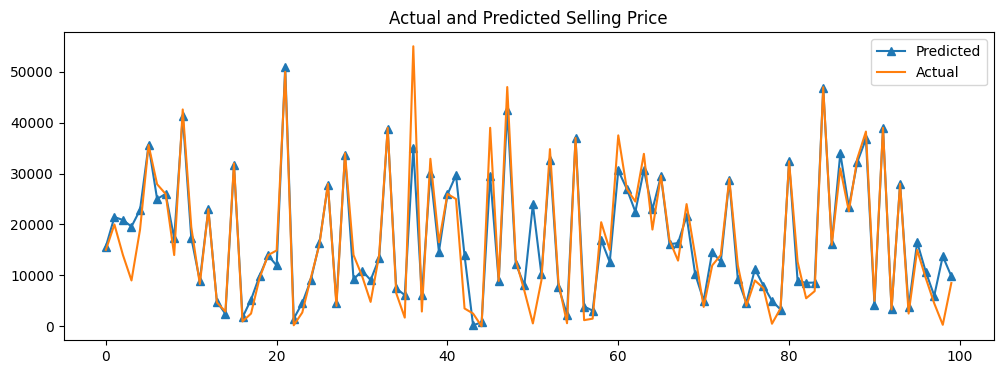

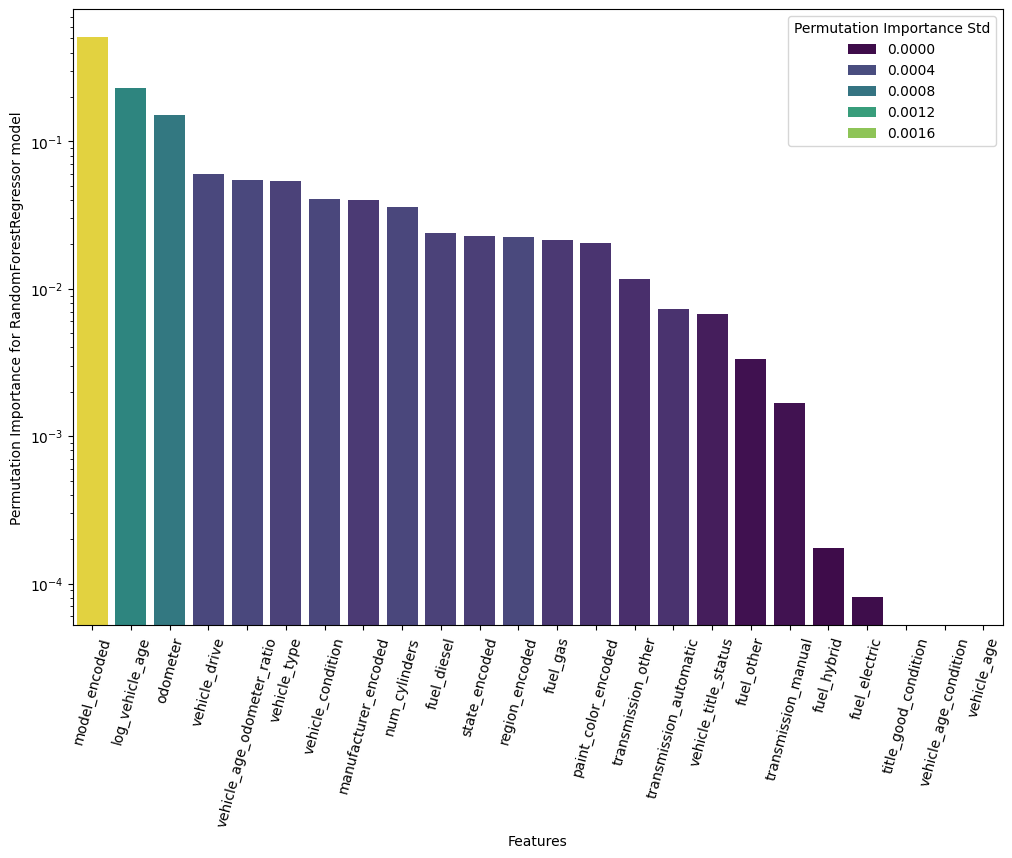

In [138]:
# Evaluate RandomForestRegressor model
start_time = time.time()
rf_score = evaluate_models(best_model_rf, 'RandomForestRegressor', y_test, X_test, y_train, X_train)
score['RandomForestRegressor'] = rf_score
end_time = time.time()
print("🕒 Duration (seconds):", end_time - start_time)

In [73]:
# Draw DecisionTreeRegressor decison tree diagram
# graph = Source(tree.export_graphviz(best_model_dt,
#                                     out_file=None,
#                                     feature_names=X_train.columns,
#                                     filled= True))
# display(SVG(graph.pipe(format='svg')))

<h4>Model Evaluation Scores</h4>

In [74]:
score

Linear Regressor  Ridge Regressor  Lasso Regressor  \
MSE Train              4.441425e+07     4.956479e+07     4.955961e+07   
MSE Test               4.399326e+07     4.912720e+07     4.912108e+07   
RMSE Train             6.664402e+03     7.040226e+03     7.039859e+03   
RMSE Test              6.632742e+03     7.009080e+03     7.008643e+03   
MAE Train              4.331177e+03     4.727050e+03     4.724849e+03   
MAE Test               4.309288e+03     4.706869e+03     4.704857e+03   
R2 Train               7.156924e-01     6.827224e-01     6.827556e-01   
R2 Test                7.187060e-01     6.858795e-01     6.859187e-01   
Adjusted R2 Train      7.156688e-01     6.826961e-01     6.827292e-01   
Adjusted R2 Test       7.186125e-01     6.857751e-01     6.858143e-01   

                   ElasticNet Regressor  XGBRegressor  \
MSE Train                  4.955967e+07  1.827579e+07   
MSE Test                   4.912123e+07  2.305160e+07   
RMSE Train                 7.039863e+03  4.275020e+03   
RMSE Test                  7.008654e+03  4.801209e+03   
MAE Train                  4.724744e+03  2.654963e+03   
MAE Test                   4.704759e+03  2.915236e+03   
R2 Train                   6.827552e-01  8.830117e-01   
R2 Test                    6.859177e-01  8.526075e-01   
Adjusted R2 Train          6.827288e-01  8.830020e-01   
Adjusted R2 Test           6.858133e-01  8.525585e-01   

                   HistGradientBoosting Regressor  DecisionTreeRegressor  \
MSE Train                            3.049972e+07           1.538371e+07   
MSE Test                             3.105107e+07           3.089348e+07   
RMSE Train                           5.522655e+03           3.922208e+03   
RMSE Test                            5.572349e+03           5.558190e+03   
MAE Train                            3.450958e+03           2.136398e+03   
MAE Test                             3.487311e+03           3.056769e+03   
R2 Train                             8.047630e-01           9.015247e-01   
R2 Test                              8.014587e-01           8.024664e-01   
Adjusted R2 Train                    8.047468e-01           9.015165e-01   
Adjusted R2 Test                     8.013927e-01           8.024007e-01   

                   RandomForestRegressor  
MSE Train                   2.666361e+06  
MSE Test                    1.743582e+07  
RMSE Train                  1.632900e+03  
RMSE Test                   4.175622e+03  
MAE Train                   8.328990e+02  
MAE Test                    2.167751e+03  
R2 Train                    9.829319e-01  
R2 Test                     8.885149e-01  
Adjusted R2 Train           9.829305e-01  
Adjusted R2 Test            8.884779e-01

In [75]:
print(mse_train_models)
print(mse_test_models)

[44414251.109892584, 49564786.43025924, 49559609.64481494, 49559673.03898146, 18275793.585982967, 30499723.58484852, 15383714.194427473, 2666361.0889052227]
[43993262.174493834, 49127196.85019838, 49121075.362276495, 49121231.47417214, 23051603.45138221, 31051074.42003866, 30893477.770545036, 17435820.399513923]


In [104]:
# DataFrame to record MSE for train and test for all models
mse_df = pd.DataFrame({
    'mse_train': mse_train_models,
    'mse_test': mse_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='mse_test', ascending=True)
mse_df = mse_df.reset_index()
mse_df.columns = ['Model', 'MSE Train', 'MSE Test']
mse_df

Model     MSE Train      MSE Test
0            RandomForestRegressor  2.666361e+06  1.743582e+07
1                     XGBRegressor  1.827579e+07  2.305160e+07
2            DecisionTreeRegressor  1.538371e+07  3.089348e+07
3  Hist GradientBoosting Regressor  3.049972e+07  3.105107e+07
4                 LinearRegression  4.441425e+07  4.399326e+07
5                            Lasso  4.955961e+07  4.912108e+07
6                       ElasticNet  4.955967e+07  4.912123e+07
7                            Ridge  4.956479e+07  4.912720e+07

In [77]:
# Create Line Plot for Error Metrics for all models
def plot_models_loss_function(df, ylabel, title, file_name, metric1, metric2):
    plt.figure(figsize=(12,5))
    plt.plot(df['Model'], df[metric1], marker='o', linestyle='-', label=metric1, color='blue')
    plt.plot(df['Model'], df[metric2], marker='s', linestyle='--', label=metric2, color='red')
    
    # Add Labels & Title
    plt.xlabel("Models", fontsize=12)
    wrap_labels(plt.gca(), 20, len(df))
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.savefig(f'images/{file_name}')
    plt.show()

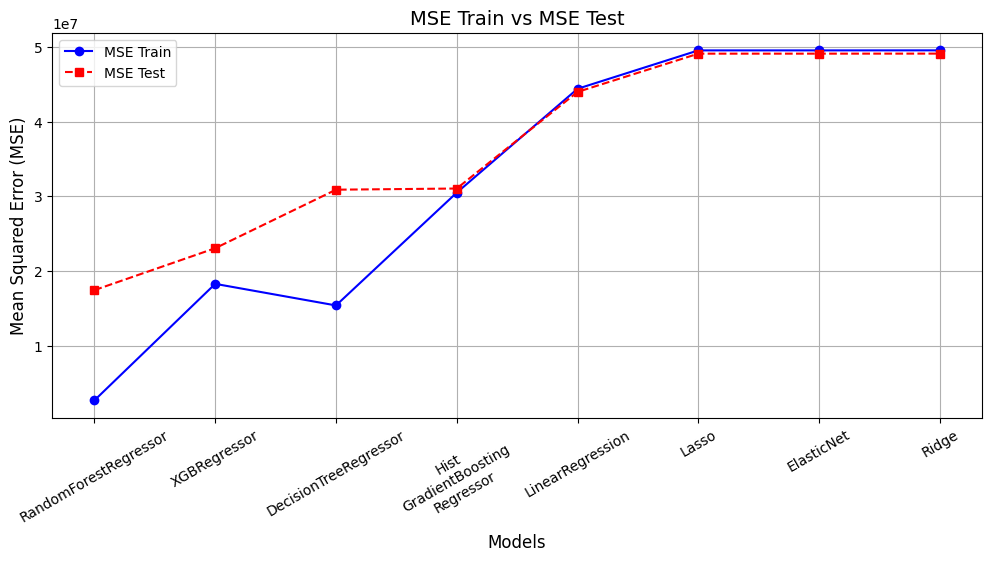

In [78]:
plot_models_loss_function(mse_df, 'Mean Squared Error (MSE)', 
                          'MSE Train vs MSE Test', 'model_mse_evaluation.png',
                          'MSE Train', 'MSE Test')

In [105]:
# DataFrame to record RMSE for train and test for all models
rmse_df = pd.DataFrame({
    'rmse_train': rmse_train_models,
    'rmse_test': rmse_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='rmse_test', ascending=True)
rmse_df = rmse_df.reset_index()
rmse_df.columns = ['Model', 'RMSE Train', 'RMSE Test']
rmse_df

Model   RMSE Train    RMSE Test
0            RandomForestRegressor  1632.899595  4175.622157
1                     XGBRegressor  4275.019718  4801.208541
2            DecisionTreeRegressor  3922.207821  5558.190152
3  Hist GradientBoosting Regressor  5522.655483  5572.349094
4                 LinearRegression  6664.401782  6632.741679
5                            Lasso  7039.858638  7008.642904
6                       ElasticNet  7039.863141  7008.654042
7                            Ridge  7040.226305  7009.079601

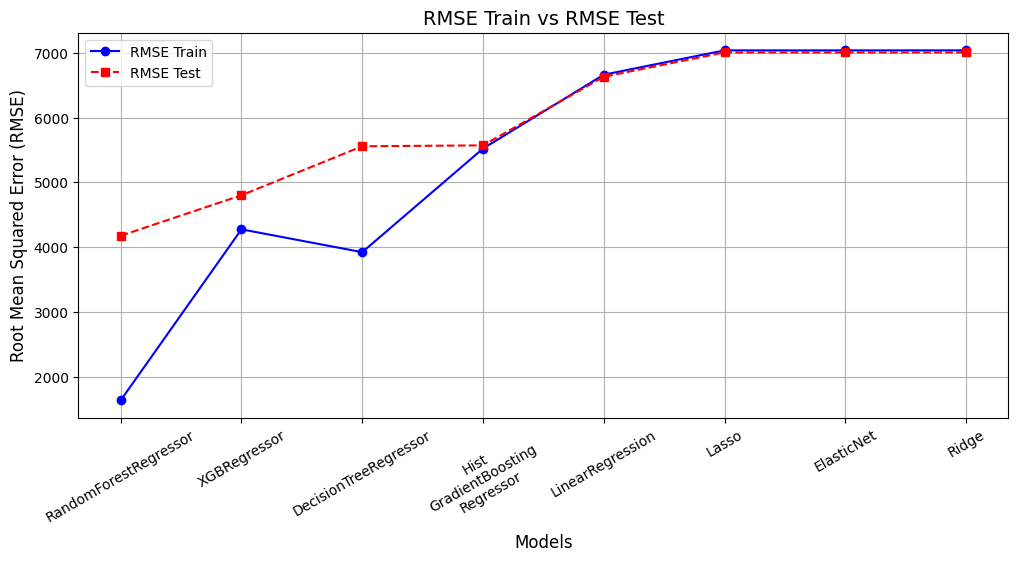

In [80]:
# Create Line Plot for MSE for all models
plot_models_loss_function(rmse_df, 'Root Mean Squared Error (RMSE)', 
                          'RMSE Train vs RMSE Test', 'model_rmse_evaluation.png',
                          'RMSE Train', 'RMSE Test')

In [106]:
# DataFrame to record MAE for train and test for all models
mae_df = pd.DataFrame({
    'mae_train': mae_train_models,
    'mae_test': mae_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='mae_test', ascending=True)
mae_df = mae_df.reset_index()
mae_df.columns = ['Model', 'MAE Train', 'MAE Test']
mae_df

Model    MAE Train     MAE Test
0            RandomForestRegressor   832.898984  2167.751444
1                     XGBRegressor  2654.962770  2915.236030
2            DecisionTreeRegressor  2136.398233  3056.768595
3  Hist GradientBoosting Regressor  3450.957879  3487.311411
4                 LinearRegression  4331.176698  4309.288468
5                       ElasticNet  4724.744481  4704.759377
6                            Lasso  4724.848829  4704.857027
7                            Ridge  4727.050396  4706.868559

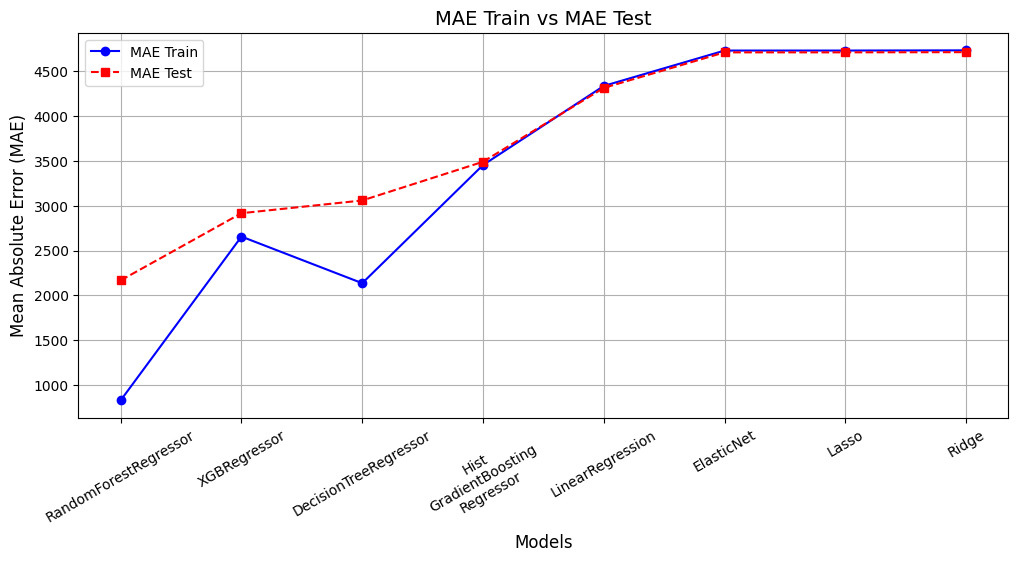

In [82]:
# Create Line Plot for MAE for all models
plot_models_loss_function(mae_df, 'Mean Absolute Error (MAE)', 
                          'MAE Train vs MAE Test', 'model_mae_evaluation.png',
                          'MAE Train', 'MAE Test')

In [107]:
# DataFrame to record R2 Score for train and test for all models
r2_df = pd.DataFrame({
    'r2_train': r2_train_models,
    'r2_test': r2_test_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='r2_test', ascending=True)
r2_df = r2_df.reset_index()
r2_df.columns = ['Model', 'R2 Score Train', 'R2 Score Test']
r2_df

Model  R2 Score Train  R2 Score Test
0                            Ridge        0.682722       0.685880
1                       ElasticNet        0.682755       0.685918
2                            Lasso        0.682756       0.685919
3                 LinearRegression        0.715692       0.718706
4  Hist GradientBoosting Regressor        0.804763       0.801459
5            DecisionTreeRegressor        0.901525       0.802466
6                     XGBRegressor        0.883012       0.852607
7            RandomForestRegressor        0.982932       0.888515

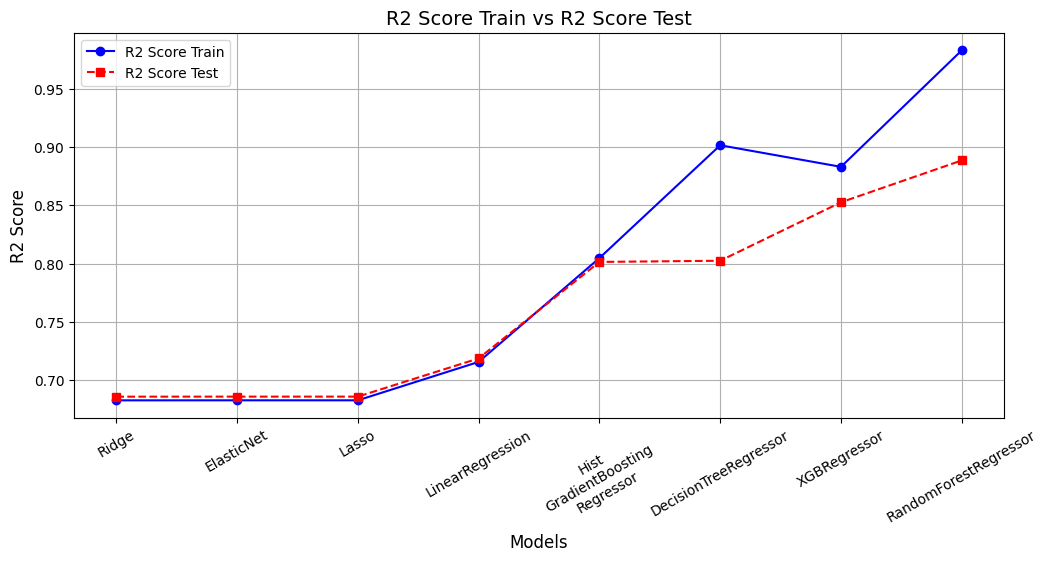

In [84]:
# Create Line Plot for R2 Score for all models
plot_models_loss_function(r2_df, 'R2 Score', 
                          'R2 Score Train vs R2 Score Test', 'model_r2_evaluation.png',
                          'R2 Score Train', 'R2 Score Test')

### Summary of Model Evaluation

* Defined model evaluation method which will perform multiple tasks as below:
  * Calculate MSE, RMSE, MAE, R2 score for train and test target variable.
  * Plot line chart for actual and predicted target price values.
  * Calculate permutation importance of feature and plot a bar graph in the order of importance of features.
* Perform model evalaution for each of the 6 models based on errors.
* Plot line chart of MSE train and MSE test for each of the models trained.

#### Evaluation Adjustment
* We did few adjustments during multiple iterations of fixing issues and fine tuning model.
  * Data Leakage Issue
    * Price imputation cause data leakage to the model. Due to which we saw R2 score of 0.99.
  * Model Accuracy Improvement
    * Orginally tried 4 regression models (LinearRegression, Ridge, Lasso and ElasticNet) and R2 score was 0.53
    * Tried 2 additional models (XGBoostRegressor and HistGradientBoostingRegressor) which improved R2 score to 0.82 and 0.8 for test data respectively.

### 5. Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [85]:
from joblib import dump, load
# Save the models to a joblib file

def save_models():
    dump(best_model_lr, 'models/lr_model.joblib')
    dump(best_model_rcv, 'models/ridge_model.joblib')
    dump(best_model_lcv, 'models/lasso_model.joblib')
    dump(best_model_ecv, 'models/lasticnet_model.joblib')
    dump(best_model_xg, 'models/xgb_model.joblib')
    dump(best_model_hgb, 'models/hgb_model.joblib')
    dump(best_model_dt, 'models/dt_model.joblib')
    dump(best_model_rf, 'models/rf_model.joblib')

save_models()

In [108]:
# Function to load the model from joblib file and calculate errors
mse_valid_models = []
rmse_valid_models = []
mae_valid_models = []
r2_valid_models = []
adjusted_r2_valid_models = []

def load_and_predict(model_name):
    X_valid = data_valid.drop('price', axis=1)
    y_valid = data_valid['price']

    load_model = None
    if model_name == 'LinearRegression':
        load_model = load('models/lr_model.joblib')
    elif model_name == 'Ridge':
        load_model = load('models/ridge_model.joblib')
    elif model_name == 'Lasso':
        load_model = load('models/lasso_model.joblib')
    elif model_name == 'ElasticNet':
        load_model = load('models/lasticnet_model.joblib')
    elif model_name == 'XGBRegressor':
        load_model = load('models/xgb_model.joblib')
    elif model_name == 'HistGradientBoostingRegressor':
        load_model = load('models/hgb_model.joblib')
    elif model_name == 'DecisionTreeRegressor':
        load_model = load('models/dt_model.joblib')
    elif model_name == 'RandomForestRegressor':
        load_model = load('models/rf_model.joblib')
    
    new_test_preds = load_model.predict(X_valid)
    # Sanity Check
    mse = mean_squared_error(y_valid, new_test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, new_test_preds)
    r2 = r2_score(y_valid, new_test_preds)
    adjusted_r2 = adjusted_r2_score(y_valid, new_test_preds, X_valid.shape[1])
    
    mse_valid_models.append(mse)
    rmse_valid_models.append(rmse)
    mae_valid_models.append(mae)
    r2_valid_models.append(r2)
    adjusted_r2_valid_models.append(adjusted_r2)
    
    print(f"MSE for {model_name}:", mse)
    print(f"RMSE for {model_name}:", rmse)
    print(f"MAE for {model_name}:", mae)
    print(f"R2 for {model_name}:", r2)
    print(f"Adjusted R2 for {model_name}:", adjusted_r2)

In [109]:
load_and_predict('LinearRegression')

MSE for LinearRegression: 43951666.2033236
RMSE for LinearRegression: 6629.605282618536
MAE for LinearRegression: 4319.686118119217
R2 for LinearRegression: 0.7185307019114651
Adjusted R2 for LinearRegression: 0.7183622456845848


In [110]:
load_and_predict('Ridge')

MSE for Ridge: 49009033.03122341
RMSE for Ridge: 7000.645186782674
MAE for Ridge: 4709.92484244238
R2 for Ridge: 0.6861429993693131
Adjusted R2 for Ridge: 0.6859551594646939


In [111]:
load_and_predict('Lasso')

MSE for Lasso: 49009008.39277798
RMSE for Lasso: 7000.643427055686
MAE for Lasso: 4707.879121640515
R2 for Lasso: 0.6861431571555028
Adjusted R2 for Lasso: 0.6859553173453168


In [112]:
load_and_predict('ElasticNet')

MSE for ElasticNet: 49008390.972602576
RMSE for ElasticNet: 7000.599329529049
MAE for ElasticNet: 4707.764872498448
R2 for ElasticNet: 0.686147111154029
Adjusted R2 for ElasticNet: 0.6859592737102669


In [113]:
load_and_predict('XGBRegressor')

MSE for XGBRegressor: 23512953.864447437
RMSE for XGBRegressor: 4849.015762445761
MAE for XGBRegressor: 2931.126052434308
R2 for XGBRegressor: 0.8494215306969713
Adjusted R2 for XGBRegressor: 0.8493314111672022


In [114]:
load_and_predict('HistGradientBoostingRegressor')

MSE for HistGradientBoostingRegressor: 31338779.025083985
RMSE for HistGradientBoostingRegressor: 5598.104949452447
MAE for HistGradientBoostingRegressor: 3493.0467796196554
R2 for HistGradientBoostingRegressor: 0.7993044428774111
Adjusted R2 for HistGradientBoostingRegressor: 0.7991843288311045


In [115]:
load_and_predict('DecisionTreeRegressor')

MSE for DecisionTreeRegressor: 32182448.56317908
RMSE for DecisionTreeRegressor: 5672.957655683593
MAE for DecisionTreeRegressor: 3101.3275049098647
R2 for DecisionTreeRegressor: 0.7939015288762044
Adjusted R2 for DecisionTreeRegressor: 0.7937781812462956


In [116]:
load_and_predict('RandomForestRegressor')

MSE for RandomForestRegressor: 18273000.80818823
RMSE for RandomForestRegressor: 4274.693065962541
MAE for RandomForestRegressor: 2199.3310669177313
R2 for RandomForestRegressor: 0.8829785271926041
Adjusted R2 for RandomForestRegressor: 0.8829084911499274


In [117]:
# DataFrame to record MSE for test and validation for all models
v_mse_df = pd.DataFrame({
    'mse_test': mse_test_models,
    'mse_valid': mse_valid_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='mse_valid', ascending=True)
v_mse_df = v_mse_df.reset_index()
v_mse_df.columns = ['Model', 'MSE Test', 'MSE Validation']
v_mse_df

Model      MSE Test  MSE Validation
0            RandomForestRegressor  1.743582e+07    1.827300e+07
1                     XGBRegressor  2.305160e+07    2.351295e+07
2  Hist GradientBoosting Regressor  3.105107e+07    3.133878e+07
3            DecisionTreeRegressor  3.089348e+07    3.218245e+07
4                 LinearRegression  4.399326e+07    4.395167e+07
5                       ElasticNet  4.912123e+07    4.900839e+07
6                            Lasso  4.912108e+07    4.900901e+07
7                            Ridge  4.912720e+07    4.900903e+07

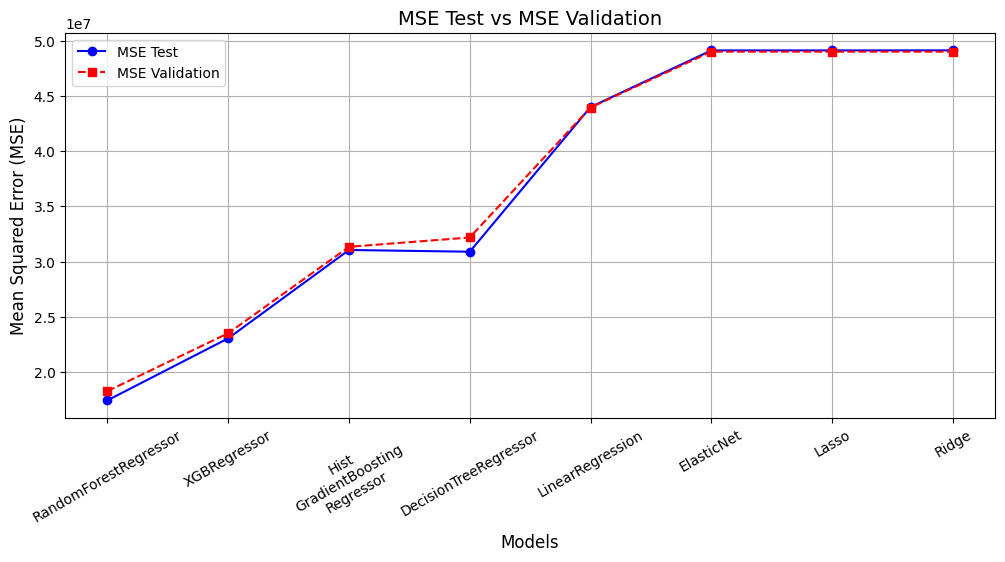

In [118]:
# Create Line Plot for MSE for all models
plot_models_loss_function(v_mse_df, 'Mean Squared Error (MSE)', 
                          'MSE Test vs MSE Validation', 'model_mse_evaluation_for_validation.png',
                          'MSE Test', 'MSE Validation')

In [119]:
# DataFrame to record MAE for test and validation for all models
v_mae_df = pd.DataFrame({
    'mae_test': mae_test_models,
    'mae_valid': mae_valid_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='mae_valid', ascending=True)
v_mae_df = v_mae_df.reset_index()
v_mae_df.columns = ['Model', 'MAE Test', 'MAE Validation']
v_mae_df

Model     MAE Test  MAE Validation
0            RandomForestRegressor  2167.751444     2199.331067
1                     XGBRegressor  2915.236030     2931.126052
2            DecisionTreeRegressor  3056.768595     3101.327505
3  Hist GradientBoosting Regressor  3487.311411     3493.046780
4                 LinearRegression  4309.288468     4319.686118
5                       ElasticNet  4704.759377     4707.764872
6                            Lasso  4704.857027     4707.879122
7                            Ridge  4706.868559     4709.924842

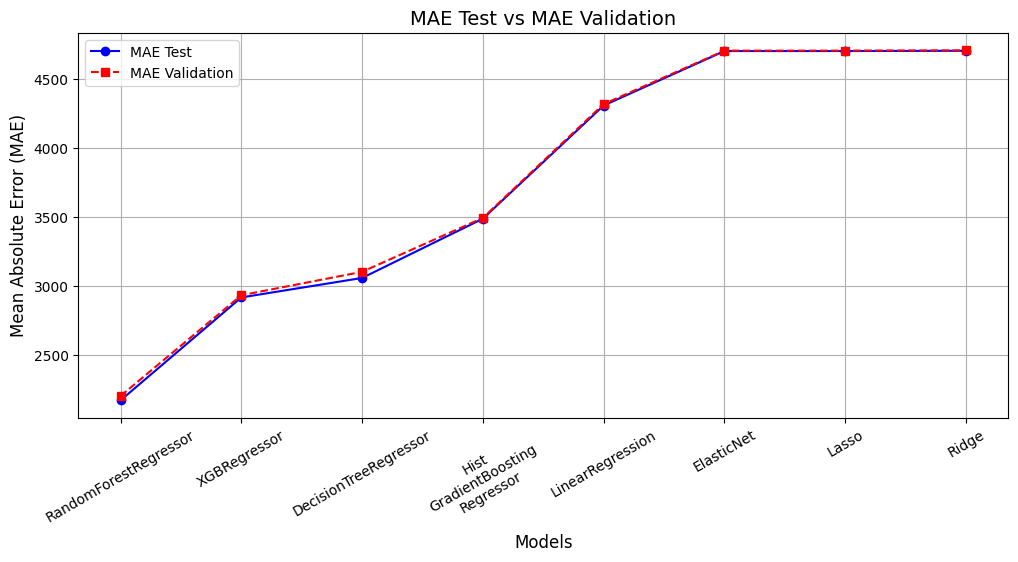

In [120]:
# Create Line Plot for MAE for all models
plot_models_loss_function(v_mae_df, 'Mean Absolute Error (MAE)', 
                          'MAE Test vs MAE Validation', 'model_mae_evaluation_for_validation.png',
                          'MAE Test', 'MAE Validation')

In [121]:
# DataFrame to record R2 Score for test and validation for all models
v_r2_df = pd.DataFrame({
    'r2_test': r2_test_models,
    'r2_valid': r2_valid_models
}, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'XGBRegressor', 
          'Hist GradientBoosting Regressor', 'DecisionTreeRegressor', 'RandomForestRegressor']).sort_values(by='r2_valid', ascending=True)
v_r2_df = v_r2_df.reset_index()
v_r2_df.columns = ['Model', 'R2 Score Test', 'R2 Score Validation']
v_r2_df

Model  R2 Score Test  R2 Score Validation
0                            Ridge       0.685880             0.686143
1                            Lasso       0.685919             0.686143
2                       ElasticNet       0.685918             0.686147
3                 LinearRegression       0.718706             0.718531
4            DecisionTreeRegressor       0.802466             0.793902
5  Hist GradientBoosting Regressor       0.801459             0.799304
6                     XGBRegressor       0.852607             0.849422
7            RandomForestRegressor       0.888515             0.882979

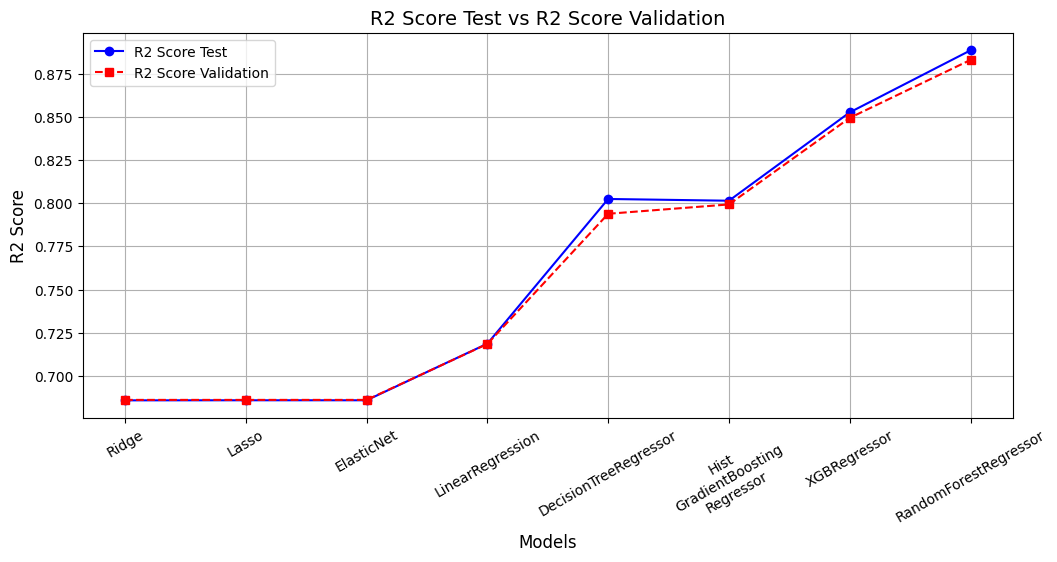

In [122]:
# Create Line Plot for R2 Score for all models
plot_models_loss_function(v_r2_df, 'R2 Score', 
                          'R2 Score Test vs R2 Score Validation', 'model_r2_evaluation_for_validation.png',
                          'R2 Score Test', 'R2 Score Validation')

### Summary of Model Deployment

* Utilized joblib library to dump and load model
* Used validation data set (unseen data) to validate model performance and observed consistency with training results.

In [101]:
nb_end_time = time.time()
print("🕒 Duration to run notebook (minutes):", (nb_end_time - nb_start_time) / 60)

🕒 Duration to run notebook (minutes): 24.525826064745583


<H3>Final summary is available in README.md</H3>